In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

In [2]:
# Use cuda if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

#### FUNCTIONS -- CLASES

In [3]:
# Model checkpoint
model_checkpoint = "microsoft/deberta-v3-base"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Load the model
model = AutoModel.from_pretrained("microsoft/deberta-v3-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical 

In [4]:
def preprocess_function(dataset):
    return tokenizer(dataset["text"], padding="max_length", truncation=True)

In [5]:
def preprocess_data(droped_columns):
    
    # Load the data already with the index column
    train = pd.read_csv('data/train.csv', index_col=0)
    official_dev = pd.read_csv('data/test.csv', index_col=0)

    # Drop the columns
    train = train.drop(columns=droped_columns)
    official_dev = official_dev.drop(columns=droped_columns)

    # Split train data into train and dev with sklearn train_test_split
    train, dev = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

    # Save the index of the rows with nan text
    print("Dropped from train set: ", train[train['text'].isnull()].index)
    print("Dropped from dev set: ", dev[dev['text'].isnull()].index)
    print("Dropped from official dev set: ", official_dev[official_dev['text'].isnull()].index)

    # Delete rows with NaN in the text column
    train = train.dropna(subset=['text'])
    dev = dev.dropna(subset=['text'])
    official_dev = official_dev.dropna(subset=['text'])

    # Transfrom data frame into a dataset
    train_data = Dataset.from_pandas(train)
    dev_data = Dataset.from_pandas(dev)
    official_dev_data = Dataset.from_pandas(official_dev)

    train_dataset = train_data.map(
    preprocess_function, 
    batched=True
    )
    eval_dataset = dev_data.map(
        preprocess_function, 
        batched=True
    )
    official_dev_dataset = official_dev_data.map(
        preprocess_function, 
        batched=True
    )

    return train_dataset, eval_dataset, official_dev_dataset

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, pos_label=1, average='binary')
    return {"f1": f1}

In [7]:
def truncate_or_pad(ids, max_len):
    if len(ids) >= max_len:
        return ids[:max_len]
    else:
        return ids + [0]*(max_len - len(ids))

In [8]:
def compute_weighted_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    
    # Crear la función de pérdida ponderada
    loss_fct = nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [9]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        return compute_weighted_loss(model, inputs, return_outputs)

### HYPERPARAMETERS:
- num_layers_to_unfreeze from the base model ---default-->  2 |  -------training for values -----> 2, 3, 4, 5
- number of epochs ---default---> 10 |  -------training for values -----> 20 epochs see when stop
- learning rate ---default---->1e-5  |  -------training for values -----> 1e-4, 1e-5, 1e-6
- learning schedule ---default---->None  |  -------training for values -----> linear, cosine, polynomial
- weight_decay (regularization) ---default-----> 0.01 |  -------training for values -----> 0.02, 0.05, 0.1

In [10]:
train_dataset, eval_dataset, official_dev_dataset = preprocess_data(['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])

Dropped from train set:  Int64Index([], dtype='int64')
Dropped from dev set:  Int64Index([], dtype='int64')
Dropped from official dev set:  Int64Index([434], dtype='int64')


  0%|          | 0/7 [00:00<?, ?ba/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 3/3 [00:00<00:00,  8.16ba/s]


In [11]:
# Save train and dev datasets
train_dataset.save_to_disk('data/train_dataset')
eval_dataset.save_to_disk('data/eval_dataset')

In [10]:
# Load the train and dev datasets
train_dataset = Dataset.load_from_disk('data/train_dataset')
eval_dataset = Dataset.load_from_disk('data/eval_dataset')

### TRAIN FUNCTION

In [26]:
## ATENTION! THIS FUNCTION HAS BEEN DEFINED AFTER TUNING ALL THE HYPERPARAMETERS

def train_and_collect_logs(hyperparam_value, hyperparam_name, train_dataset, eval_dataset):
    """
     Train the model while varying the specified hyperparameter.
    
    hyperparam_value: the value to test (e.g., 1e-5, 2e-5, etc.)
    hyperparam_name: a string indicating which hyperparameter is being varied 
                     ("learning_rate", "num_train_epochs", "weight_decay", "num_layers_to_unfreeze", "learning_schedule")
    
    Returns four arrays (as tuples of (step, value)) for:
      - train_loss (loss logged during training)
      - eval_loss (loss computed on the evaluation dataset)
      - eval_f1 (F1 metric on the evaluation dataset)
    """
    # Load the model and configure freezing/unfreezing
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the classification head
    for param in model.classifier.parameters():
        param.requires_grad = True

    # For the "num_layers_to_unfreeze" parameter, use the provided value; otherwise, use default value 2
    if hyperparam_name == "num_layers_to_unfreeze":
        num_layers_to_unfreeze = hyperparam_value
    else:
        num_layers_to_unfreeze = 4

    # Unfreeze the last num_layers_to_unfreeze layers of the encoder (for DeBERTa models)
    for layer in model.deberta.encoder.layer[-num_layers_to_unfreeze:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Configure training arguments; the hyperparameter of interest is updated, others remain fixed
    kwargs = {
        "output_dir": f"./results_{hyperparam_name}_{hyperparam_value}",
        "evaluation_strategy": "epoch",
        "save_strategy": "epoch",
        "per_device_train_batch_size": 4,
        "per_device_eval_batch_size": 4,
        "gradient_accumulation_steps": 2,
        "num_train_epochs": 4,
        "learning_rate": 1e-5,
        "weight_decay": 0.01,
        "lr_scheduler_type": "cosine",
        "warmup_steps": 500,
        "load_best_model_at_end": True,
        "metric_for_best_model": "f1",
        "logging_dir": f"./logs_{hyperparam_name}_{hyperparam_value}",
        "fp16": True,
        "logging_steps": 250
    }

    # Update the hyperparameter of interest
    if hyperparam_name == "learning_rate":
        kwargs["learning_rate"] = hyperparam_value
    elif hyperparam_name == "num_train_epochs":
        kwargs["num_train_epochs"] = hyperparam_value
    elif hyperparam_name == "weight_decay":
        kwargs["weight_decay"] = hyperparam_value
    elif hyperparam_name  == "learning_schedule":
        kwargs["lr_scheduler_type"]=hyperparam_value
    else:
        # For num_layers_to_unfreeze, use the default values for the others
        pass

    training_args = TrainingArguments(**kwargs)


    # Create the Trainer with the custom callback to compute training metrics
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Collect the logged information
    logs = trainer.state.log_history

    # Extract training and evaluation data
    train_loss = []
    eval_loss = []
    eval_f1 = []
    for log in logs:
        if "loss" in log and "epoch" in log:
            train_loss.append((log["epoch"], log["loss"]))
        if "eval_loss" in log:
            eval_loss.append((log["epoch"], log["eval_loss"]))
        if "eval_f1" in log:
            eval_f1.append((log["epoch"], log["eval_f1"]))

    # Sort by "step" (in case they are not ordered)
    train_loss = np.array(sorted(train_loss, key=lambda x: x[0]))
    eval_loss = np.array(sorted(eval_loss, key=lambda x: x[0]))
    eval_f1 = np.array(sorted(eval_f1, key=lambda x: x[0]))

    return train_loss, eval_loss, eval_f1

### NUMBER OF EPOCHS FOR EARLY STOPPING

In [16]:
# Testing a long epoch number to see how the model behaves
epochs = [20]
results_epochs = {}

for epoch in epochs:
    print(f"Training with epoch = {epoch}")
    results_epochs[epoch] = train_and_collect_logs(epoch, "num_train_epochs", train_dataset, eval_dataset)

Training with epoch = 20


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.3273, 'learning_rate': 9.701911589008364e-06, 'epoch': 0.6}


  5%|▍         | 836/16740 [00:36<10:49, 24.48it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
  5%|▌         | 837/16740 [00:42<10:49, 24.48it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-837
Configuration saved in ./results_num_train_epochs_20/checkpoint-837/config.json


{'eval_loss': 0.3098897337913513, 'eval_f1': 0.0, 'eval_runtime': 5.3959, 'eval_samples_per_second': 310.421, 'eval_steps_per_second': 77.652, 'epoch': 1.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-837/added_tokens.json
  6%|▌         | 1004/16740 [00:50<11:56, 21.96it/s] 

{'loss': 0.299, 'learning_rate': 9.403823178016728e-06, 'epoch': 1.19}


  9%|▉         | 1502/16740 [01:13<10:37, 23.92it/s]

{'loss': 0.2603, 'learning_rate': 9.105137395459976e-06, 'epoch': 1.79}


 10%|▉         | 1673/16740 [01:20<10:55, 22.99it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 10%|█         | 1674/16740 [01:26<10:55, 22.99it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-1674
Configuration saved in ./results_num_train_epochs_20/checkpoint-1674/config.json


{'eval_loss': 0.282895028591156, 'eval_f1': 0.20618556701030927, 'eval_runtime': 5.689, 'eval_samples_per_second': 294.426, 'eval_steps_per_second': 73.65, 'epoch': 2.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-1674/added_tokens.json
 12%|█▏        | 2002/16740 [01:41<10:07, 24.28it/s]  

{'loss': 0.2332, 'learning_rate': 8.806451612903226e-06, 'epoch': 2.39}


 15%|█▍        | 2503/16740 [02:03<09:52, 24.03it/s]

{'loss': 0.2179, 'learning_rate': 8.507765830346475e-06, 'epoch': 2.99}


 15%|█▍        | 2509/16740 [02:03<10:10, 23.30it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 15%|█▌        | 2511/16740 [02:09<10:10, 23.30it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-2511
Configuration saved in ./results_num_train_epochs_20/checkpoint-2511/config.json


{'eval_loss': 0.24398495256900787, 'eval_f1': 0.5212121212121211, 'eval_runtime': 5.4481, 'eval_samples_per_second': 307.448, 'eval_steps_per_second': 76.908, 'epoch': 3.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-2511/added_tokens.json
 18%|█▊        | 3004/16740 [02:32<09:43, 23.55it/s]  

{'loss': 0.214, 'learning_rate': 8.209677419354839e-06, 'epoch': 3.58}


 20%|█▉        | 3346/16740 [02:46<09:17, 24.03it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 20%|██        | 3348/16740 [02:52<09:17, 24.03it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-3348
Configuration saved in ./results_num_train_epochs_20/checkpoint-3348/config.json


{'eval_loss': 0.2796632647514343, 'eval_f1': 0.4727272727272727, 'eval_runtime': 5.4119, 'eval_samples_per_second': 309.503, 'eval_steps_per_second': 77.422, 'epoch': 4.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-3348/added_tokens.json
 21%|██        | 3502/16740 [02:59<09:11, 23.99it/s]  

{'loss': 0.1896, 'learning_rate': 7.911589008363202e-06, 'epoch': 4.18}


 24%|██▍       | 4005/16740 [03:21<08:28, 25.06it/s]

{'loss': 0.1901, 'learning_rate': 7.612903225806451e-06, 'epoch': 4.78}


 25%|██▌       | 4185/16740 [03:29<10:40, 19.61it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 25%|██▌       | 4185/16740 [03:34<10:40, 19.61it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-4185
Configuration saved in ./results_num_train_epochs_20/checkpoint-4185/config.json


{'eval_loss': 0.2747797966003418, 'eval_f1': 0.49462365591397844, 'eval_runtime': 5.353, 'eval_samples_per_second': 312.908, 'eval_steps_per_second': 78.274, 'epoch': 5.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-4185/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-4185/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-4185/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-4185/added_tokens.json
 27%|██▋       | 4503/16740 [03:49<08:47, 23.21it/s]  

{'loss': 0.1873, 'learning_rate': 7.314217443249701e-06, 'epoch': 5.38}


 30%|██▉       | 5004/16740 [04:11<08:14, 23.73it/s]

{'loss': 0.1811, 'learning_rate': 7.015531660692951e-06, 'epoch': 5.97}


 30%|███       | 5022/16740 [04:12<08:24, 23.22it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 30%|███       | 5022/16740 [04:17<08:24, 23.22it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-5022
Configuration saved in ./results_num_train_epochs_20/checkpoint-5022/config.json


{'eval_loss': 0.3090629279613495, 'eval_f1': 0.46792452830188674, 'eval_runtime': 5.4261, 'eval_samples_per_second': 308.692, 'eval_steps_per_second': 77.219, 'epoch': 6.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-5022/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-5022/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-5022/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-5022/added_tokens.json
 33%|███▎      | 5503/16740 [04:40<08:07, 23.05it/s]  

{'loss': 0.1695, 'learning_rate': 6.717443249701314e-06, 'epoch': 6.57}


 35%|███▌      | 5859/16740 [04:55<07:25, 24.43it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 35%|███▌      | 5859/16740 [05:00<07:25, 24.43it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-5859
Configuration saved in ./results_num_train_epochs_20/checkpoint-5859/config.json


{'eval_loss': 0.31844156980514526, 'eval_f1': 0.5217391304347826, 'eval_runtime': 5.3938, 'eval_samples_per_second': 310.544, 'eval_steps_per_second': 77.682, 'epoch': 7.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-5859/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-5859/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-5859/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-5859/added_tokens.json
 36%|███▌      | 6002/16740 [05:08<07:29, 23.90it/s]  

{'loss': 0.1668, 'learning_rate': 6.418757467144564e-06, 'epoch': 7.17}


 39%|███▉      | 6503/16740 [05:30<07:15, 23.50it/s]

{'loss': 0.151, 'learning_rate': 6.120071684587814e-06, 'epoch': 7.77}


 40%|███▉      | 6695/16740 [05:38<06:55, 24.16it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 40%|████      | 6696/16740 [05:44<06:55, 24.16it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-6696
Configuration saved in ./results_num_train_epochs_20/checkpoint-6696/config.json


{'eval_loss': 0.3632058799266815, 'eval_f1': 0.5067567567567568, 'eval_runtime': 5.3924, 'eval_samples_per_second': 310.625, 'eval_steps_per_second': 77.703, 'epoch': 8.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-6696/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-6696/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-6696/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-6696/added_tokens.json
 42%|████▏     | 7004/16740 [05:58<06:59, 23.21it/s]  

{'loss': 0.1197, 'learning_rate': 5.821385902031064e-06, 'epoch': 8.36}


 45%|████▍     | 7502/16740 [06:19<06:22, 24.15it/s]

{'loss': 0.1424, 'learning_rate': 5.523894862604541e-06, 'epoch': 8.96}


 45%|████▍     | 7532/16740 [06:21<06:28, 23.68it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 45%|████▌     | 7533/16740 [06:26<06:28, 23.68it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-7533
Configuration saved in ./results_num_train_epochs_20/checkpoint-7533/config.json


{'eval_loss': 0.3801653981208801, 'eval_f1': 0.5257142857142857, 'eval_runtime': 5.4255, 'eval_samples_per_second': 308.728, 'eval_steps_per_second': 77.228, 'epoch': 9.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-7533/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-7533/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-7533/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-7533/added_tokens.json
 48%|████▊     | 8003/16740 [06:48<06:21, 22.89it/s]  

{'loss': 0.1406, 'learning_rate': 5.225209080047791e-06, 'epoch': 9.56}


 50%|████▉     | 8369/16740 [07:03<05:50, 23.86it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 50%|█████     | 8370/16740 [07:09<05:50, 23.86it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-8370
Configuration saved in ./results_num_train_epochs_20/checkpoint-8370/config.json


{'eval_loss': 0.4027940034866333, 'eval_f1': 0.48813559322033895, 'eval_runtime': 5.435, 'eval_samples_per_second': 308.19, 'eval_steps_per_second': 77.093, 'epoch': 10.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-8370/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-8370/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-8370/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-8370/added_tokens.json
 51%|█████     | 8504/16740 [07:16<06:00, 22.87it/s]  

{'loss': 0.1129, 'learning_rate': 4.92652329749104e-06, 'epoch': 10.16}


 54%|█████▍    | 9002/16740 [07:38<05:51, 22.01it/s]

{'loss': 0.1032, 'learning_rate': 4.6278375149342895e-06, 'epoch': 10.75}


 55%|█████▍    | 9206/16740 [07:47<05:10, 24.28it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 55%|█████▌    | 9207/16740 [07:52<05:10, 24.28it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-9207
Configuration saved in ./results_num_train_epochs_20/checkpoint-9207/config.json


{'eval_loss': 0.41273462772369385, 'eval_f1': 0.5198776758409787, 'eval_runtime': 5.4277, 'eval_samples_per_second': 308.601, 'eval_steps_per_second': 77.196, 'epoch': 11.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-9207/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-9207/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-9207/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-9207/added_tokens.json
 57%|█████▋    | 9503/16740 [08:06<04:57, 24.36it/s]  

{'loss': 0.1125, 'learning_rate': 4.329151732377539e-06, 'epoch': 11.35}


 60%|█████▉    | 10004/16740 [08:28<04:42, 23.84it/s]

{'loss': 0.1054, 'learning_rate': 4.031063321385903e-06, 'epoch': 11.95}


 60%|█████▉    | 10043/16740 [08:30<04:41, 23.82it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 60%|██████    | 10044/16740 [08:35<04:41, 23.82it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-10044
Configuration saved in ./results_num_train_epochs_20/checkpoint-10044/config.json


{'eval_loss': 0.4507739543914795, 'eval_f1': 0.4878048780487804, 'eval_runtime': 5.4442, 'eval_samples_per_second': 307.669, 'eval_steps_per_second': 76.963, 'epoch': 12.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-10044/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-10044/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-10044/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-10044/added_tokens.json
 63%|██████▎   | 10502/16740 [08:56<04:53, 21.24it/s]  

{'loss': 0.0968, 'learning_rate': 3.732377538829152e-06, 'epoch': 12.54}


 65%|██████▍   | 10880/16740 [09:13<04:35, 21.27it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 65%|██████▌   | 10881/16740 [09:18<04:35, 21.27it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-10881
Configuration saved in ./results_num_train_epochs_20/checkpoint-10881/config.json


{'eval_loss': 0.4713441729545593, 'eval_f1': 0.4895104895104894, 'eval_runtime': 5.4232, 'eval_samples_per_second': 308.856, 'eval_steps_per_second': 77.26, 'epoch': 13.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-10881/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-10881/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-10881/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-10881/added_tokens.json
 66%|██████▌   | 11003/16740 [09:25<04:59, 19.13it/s]  

{'loss': 0.0935, 'learning_rate': 3.4336917562724016e-06, 'epoch': 13.14}


 69%|██████▊   | 11504/16740 [09:47<04:13, 20.63it/s]

{'loss': 0.0852, 'learning_rate': 3.1350059737156514e-06, 'epoch': 13.74}


 70%|██████▉   | 11717/16740 [09:56<03:26, 24.28it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 70%|███████   | 11718/16740 [10:01<03:26, 24.28it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-11718
Configuration saved in ./results_num_train_epochs_20/checkpoint-11718/config.json


{'eval_loss': 0.4961400628089905, 'eval_f1': 0.5206349206349206, 'eval_runtime': 5.3697, 'eval_samples_per_second': 311.938, 'eval_steps_per_second': 78.031, 'epoch': 14.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-11718/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-11718/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-11718/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-11718/added_tokens.json
 72%|███████▏  | 12002/16740 [10:14<03:23, 23.23it/s]

{'loss': 0.0596, 'learning_rate': 2.836917562724015e-06, 'epoch': 14.34}


 75%|███████▍  | 12503/16740 [10:36<03:06, 22.67it/s]

{'loss': 0.0796, 'learning_rate': 2.5382317801672642e-06, 'epoch': 14.93}


 75%|███████▍  | 12554/16740 [10:39<03:05, 22.57it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 75%|███████▌  | 12555/16740 [10:44<03:05, 22.57it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-12555
Configuration saved in ./results_num_train_epochs_20/checkpoint-12555/config.json


{'eval_loss': 0.5111023783683777, 'eval_f1': 0.514792899408284, 'eval_runtime': 5.4974, 'eval_samples_per_second': 304.691, 'eval_steps_per_second': 76.218, 'epoch': 15.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-12555/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-12555/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-12555/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-12555/added_tokens.json
 78%|███████▊  | 13004/16740 [11:04<02:46, 22.49it/s]

{'loss': 0.0676, 'learning_rate': 2.239545997610514e-06, 'epoch': 15.53}


 80%|███████▉  | 13391/16740 [11:21<02:23, 23.35it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 80%|████████  | 13392/16740 [11:27<02:23, 23.35it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-13392
Configuration saved in ./results_num_train_epochs_20/checkpoint-13392/config.json


{'eval_loss': 0.5160853862762451, 'eval_f1': 0.5063291139240507, 'eval_runtime': 5.4307, 'eval_samples_per_second': 308.429, 'eval_steps_per_second': 77.153, 'epoch': 16.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-13392/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-13392/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-13392/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-13392/added_tokens.json
 81%|████████  | 13505/16740 [11:33<02:11, 24.69it/s]

{'loss': 0.0632, 'learning_rate': 1.940860215053764e-06, 'epoch': 16.13}


 84%|████████▎ | 14003/16740 [11:55<02:01, 22.56it/s]

{'loss': 0.0712, 'learning_rate': 1.6427718040621269e-06, 'epoch': 16.73}


 85%|████████▍ | 14228/16740 [12:05<01:44, 24.07it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 85%|████████▌ | 14229/16740 [12:10<01:44, 24.07it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-14229
Configuration saved in ./results_num_train_epochs_20/checkpoint-14229/config.json


{'eval_loss': 0.531342089176178, 'eval_f1': 0.47719298245614034, 'eval_runtime': 5.4445, 'eval_samples_per_second': 307.652, 'eval_steps_per_second': 76.959, 'epoch': 17.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-14229/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-14229/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-14229/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-14229/added_tokens.json
 87%|████████▋ | 14504/16740 [12:23<01:34, 23.71it/s]

{'loss': 0.0619, 'learning_rate': 1.3440860215053765e-06, 'epoch': 17.32}


 90%|████████▉ | 15002/16740 [12:45<01:18, 22.22it/s]

{'loss': 0.0595, 'learning_rate': 1.0454002389486263e-06, 'epoch': 17.92}


 90%|████████▉ | 15065/16740 [12:47<01:12, 23.07it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 90%|█████████ | 15066/16740 [12:53<01:12, 23.07it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-15066
Configuration saved in ./results_num_train_epochs_20/checkpoint-15066/config.json


{'eval_loss': 0.5356197357177734, 'eval_f1': 0.5033112582781457, 'eval_runtime': 5.4644, 'eval_samples_per_second': 306.531, 'eval_steps_per_second': 76.679, 'epoch': 18.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-15066/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-15066/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-15066/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-15066/added_tokens.json
 93%|█████████▎| 15502/16740 [13:13<00:53, 23.16it/s]

{'loss': 0.0576, 'learning_rate': 7.467144563918759e-07, 'epoch': 18.52}


 95%|█████████▍| 15901/16740 [13:30<00:40, 20.79it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 95%|█████████▌| 15903/16740 [13:36<00:40, 20.79it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-15903
Configuration saved in ./results_num_train_epochs_20/checkpoint-15903/config.json


{'eval_loss': 0.5435531139373779, 'eval_f1': 0.5128205128205128, 'eval_runtime': 5.4321, 'eval_samples_per_second': 308.35, 'eval_steps_per_second': 77.133, 'epoch': 19.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-15903/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-15903/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-15903/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-15903/added_tokens.json
 96%|█████████▌| 16002/16740 [13:41<00:33, 22.17it/s]

{'loss': 0.0488, 'learning_rate': 4.4862604540023896e-07, 'epoch': 19.12}


 99%|█████████▊| 16503/16740 [14:02<00:09, 23.77it/s]

{'loss': 0.0492, 'learning_rate': 1.4994026284348865e-07, 'epoch': 19.71}


100%|██████████| 16740/16740 [14:13<00:00, 23.11it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
100%|██████████| 16740/16740 [14:18<00:00, 23.11it/s]Saving model checkpoint to ./results_num_train_epochs_20/checkpoint-16740
Configuration saved in ./results_num_train_epochs_20/checkpoint-16740/config.json


{'eval_loss': 0.5461832284927368, 'eval_f1': 0.5126582278481012, 'eval_runtime': 5.5567, 'eval_samples_per_second': 301.439, 'eval_steps_per_second': 75.405, 'epoch': 20.0}


Model weights saved in ./results_num_train_epochs_20/checkpoint-16740/pytorch_model.bin
tokenizer config file saved in ./results_num_train_epochs_20/checkpoint-16740/tokenizer_config.json
Special tokens file saved in ./results_num_train_epochs_20/checkpoint-16740/special_tokens_map.json
added tokens file saved in ./results_num_train_epochs_20/checkpoint-16740/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_num_train_epochs_20/checkpoint-7533 (score: 0.5257142857142857).
100%|██████████| 16740/16740 [14:21<00:00, 19.42it/s]

{'train_runtime': 861.9412, 'train_samples_per_second': 155.463, 'train_steps_per_second': 19.421, 'train_loss': 0.13564727314911434, 'epoch': 20.0}


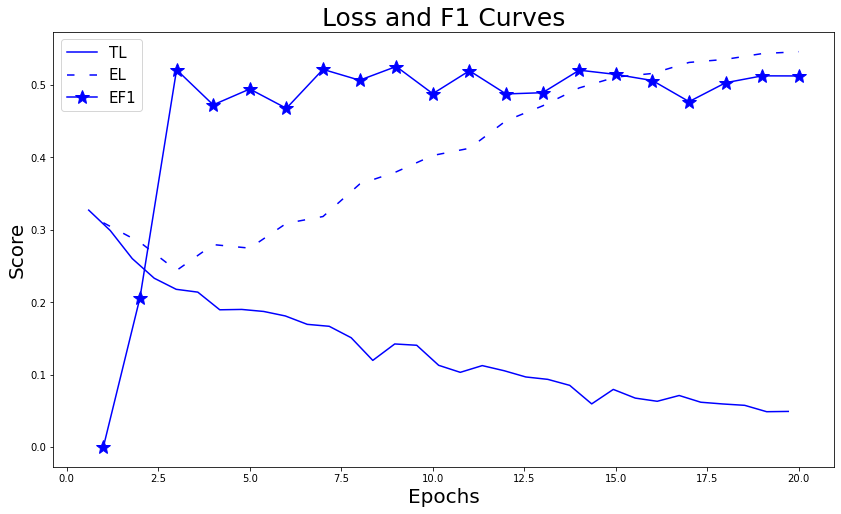

In [30]:
colors = {20: 'blue'}

plt.figure(figsize=(14, 8))
for epochs, (train_loss, eval_loss, eval_f1) in results_epochs.items():
    color = colors[epochs]
    if len(train_loss) > 0:
        plt.plot(train_loss[:, 0], train_loss[:, 1],
                 label=f"TL",
                 color=color, linestyle='-')
    if len(eval_loss) > 0:
        line, = plt.plot(eval_loss[:, 0], eval_loss[:, 1],
                 label=f"EL",
                 color=color, linestyle='--')
        line.set_dashes([5, 10])
    if len(eval_f1) > 0:
        plt.plot(eval_f1[:, 0], eval_f1[:, 1],
                 label=f"EF1",
                 color=color, linestyle='-', marker='*', markersize=15)

plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.title("Loss and F1 Curves", fontsize=25)
plt.legend(prop={'size': 15}, ncol=1)
plt.show()

- Stop training  on epoch 4 epochs at most
- Score: 0.515

### NUMBER OF LAYERS TO UNFREEZE FROM THE BASE MODEL

In [19]:
# Testing how many layers to unfreeze in the base model
n_layers = [2, 3, 4, 5]
results_n_layers = {}

for layers in n_layers:
    print(f"Training with unfrozen layer = {layers}")
    results_n_layers[layers] = train_and_collect_logs(layers, "num_layers_to_unfreeze", train_dataset, eval_dataset)

Training with unfrozen layer = 2


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.3883, 'learning_rate': 9.256272401433693e-06, 'epoch': 0.3}


 15%|█▌        | 504/3348 [00:22<01:55, 24.64it/s]

{'loss': 0.2909, 'learning_rate': 8.509557945041816e-06, 'epoch': 0.6}


 22%|██▏       | 750/3348 [00:32<01:51, 23.40it/s]

{'loss': 0.3206, 'learning_rate': 7.765830346475508e-06, 'epoch': 0.9}


 25%|██▌       | 837/3348 [00:36<01:45, 23.83it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:42<01:45, 23.83it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_2/checkpoint-837
Configuration saved in ./results_num_layers_to_unfreeze_2/checkpoint-837/config.json


{'eval_loss': 0.30944564938545227, 'eval_f1': 0.0, 'eval_runtime': 5.4599, 'eval_samples_per_second': 306.78, 'eval_steps_per_second': 76.741, 'epoch': 1.0}


Model weights saved in ./results_num_layers_to_unfreeze_2/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_2/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-837/added_tokens.json
 30%|██▉       | 1004/3348 [00:50<01:38, 23.75it/s]

{'loss': 0.2727, 'learning_rate': 7.019115890083633e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:01<01:28, 23.68it/s]

{'loss': 0.2772, 'learning_rate': 6.272401433691757e-06, 'epoch': 1.49}


 45%|████▍     | 1502/3348 [01:12<01:18, 23.47it/s]

{'loss': 0.247, 'learning_rate': 5.525686977299881e-06, 'epoch': 1.79}


 50%|████▉     | 1673/3348 [01:20<01:09, 23.96it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:25<01:09, 23.96it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_2/checkpoint-1674
Configuration saved in ./results_num_layers_to_unfreeze_2/checkpoint-1674/config.json


{'eval_loss': 0.2743188738822937, 'eval_f1': 0.057803468208092484, 'eval_runtime': 5.4115, 'eval_samples_per_second': 309.529, 'eval_steps_per_second': 77.428, 'epoch': 2.0}


Model weights saved in ./results_num_layers_to_unfreeze_2/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_2/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1754/3348 [01:30<01:10, 22.71it/s]

{'loss': 0.2283, 'learning_rate': 4.7789725209080055e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [01:40<00:56, 23.90it/s]

{'loss': 0.2567, 'learning_rate': 4.032258064516129e-06, 'epoch': 2.39}


 67%|██████▋   | 2252/3348 [01:51<00:49, 22.09it/s]

{'loss': 0.2295, 'learning_rate': 3.2855436081242537e-06, 'epoch': 2.69}


 75%|███████▍  | 2504/3348 [02:02<00:36, 23.18it/s]

{'loss': 0.2352, 'learning_rate': 2.538829151732378e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:02<00:36, 22.80it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:08<00:36, 22.80it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_2/checkpoint-2511
Configuration saved in ./results_num_layers_to_unfreeze_2/checkpoint-2511/config.json


{'eval_loss': 0.24220171570777893, 'eval_f1': 0.450381679389313, 'eval_runtime': 5.438, 'eval_samples_per_second': 308.017, 'eval_steps_per_second': 77.05, 'epoch': 3.0}


Model weights saved in ./results_num_layers_to_unfreeze_2/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_2/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2753/3348 [02:20<00:26, 22.80it/s]

{'loss': 0.2489, 'learning_rate': 1.7951015531660695e-06, 'epoch': 3.29}


 90%|████████▉ | 3002/3348 [02:31<00:14, 24.12it/s]

{'loss': 0.216, 'learning_rate': 1.0483870967741936e-06, 'epoch': 3.58}


 97%|█████████▋| 3254/3348 [02:41<00:03, 23.83it/s]

{'loss': 0.2023, 'learning_rate': 3.016726403823178e-07, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [02:45<00:00, 24.06it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [02:51<00:00, 24.06it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_2/checkpoint-3348
Configuration saved in ./results_num_layers_to_unfreeze_2/checkpoint-3348/config.json


{'eval_loss': 0.24537284672260284, 'eval_f1': 0.46616541353383456, 'eval_runtime': 5.4125, 'eval_samples_per_second': 309.471, 'eval_steps_per_second': 77.414, 'epoch': 4.0}


Model weights saved in ./results_num_layers_to_unfreeze_2/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_2/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_2/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_num_layers_to_unfreeze_2/checkpoint-3348 (score: 0.46616541353383456).
100%|██████████| 3348/3348 [02:52<00:00, 19.38it/s]


{'train_runtime': 172.7521, 'train_samples_per_second': 155.136, 'train_steps_per_second': 19.38, 'train_loss': 0.2609156417163042, 'epoch': 4.0}
Training with unfrozen layer = 3


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.3496, 'learning_rate': 9.253285543608125e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:24<02:09, 21.89it/s]

{'loss': 0.2768, 'learning_rate': 8.509557945041816e-06, 'epoch': 0.6}


 22%|██▏       | 750/3348 [00:36<01:59, 21.71it/s]

{'loss': 0.3072, 'learning_rate': 7.76284348864994e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [00:40<01:55, 21.67it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [00:46<01:55, 21.67it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_3/checkpoint-837
Configuration saved in ./results_num_layers_to_unfreeze_3/checkpoint-837/config.json


{'eval_loss': 0.2986517548561096, 'eval_f1': 0.13333333333333333, 'eval_runtime': 5.3969, 'eval_samples_per_second': 310.361, 'eval_steps_per_second': 77.637, 'epoch': 1.0}


Model weights saved in ./results_num_layers_to_unfreeze_3/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_3/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-837/added_tokens.json
 30%|██▉       | 1004/3348 [00:55<01:47, 21.71it/s]

{'loss': 0.2409, 'learning_rate': 7.0161290322580654e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:07<01:38, 21.24it/s]

{'loss': 0.2518, 'learning_rate': 6.272401433691757e-06, 'epoch': 1.49}


 45%|████▍     | 1501/3348 [01:19<01:28, 20.84it/s]

{'loss': 0.2252, 'learning_rate': 5.525686977299881e-06, 'epoch': 1.79}


 50%|████▉     | 1672/3348 [01:27<01:20, 20.75it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:33<01:20, 20.75it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_3/checkpoint-1674
Configuration saved in ./results_num_layers_to_unfreeze_3/checkpoint-1674/config.json


{'eval_loss': 0.29368579387664795, 'eval_f1': 0.37333333333333335, 'eval_runtime': 5.3873, 'eval_samples_per_second': 310.917, 'eval_steps_per_second': 77.776, 'epoch': 2.0}


Model weights saved in ./results_num_layers_to_unfreeze_3/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_3/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:38<01:16, 20.79it/s]

{'loss': 0.2119, 'learning_rate': 4.7789725209080055e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [01:50<01:03, 21.30it/s]

{'loss': 0.2267, 'learning_rate': 4.032258064516129e-06, 'epoch': 2.39}


 67%|██████▋   | 2251/3348 [02:02<00:52, 20.86it/s]

{'loss': 0.2164, 'learning_rate': 3.2885304659498215e-06, 'epoch': 2.69}


 75%|███████▍  | 2504/3348 [02:15<00:40, 20.78it/s]

{'loss': 0.2058, 'learning_rate': 2.541816009557945e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:15<00:40, 20.53it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:21<00:40, 20.53it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_3/checkpoint-2511
Configuration saved in ./results_num_layers_to_unfreeze_3/checkpoint-2511/config.json


{'eval_loss': 0.2532913386821747, 'eval_f1': 0.511326860841424, 'eval_runtime': 5.5832, 'eval_samples_per_second': 300.008, 'eval_steps_per_second': 75.047, 'epoch': 3.0}


Model weights saved in ./results_num_layers_to_unfreeze_3/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_3/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2753/3348 [02:35<00:29, 19.99it/s]

{'loss': 0.2166, 'learning_rate': 1.7951015531660695e-06, 'epoch': 3.29}


 90%|████████▉ | 3002/3348 [02:47<00:16, 21.49it/s]

{'loss': 0.1977, 'learning_rate': 1.0483870967741936e-06, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [02:59<00:04, 21.60it/s]

{'loss': 0.1832, 'learning_rate': 3.016726403823178e-07, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:04<00:00, 21.06it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:09<00:00, 21.06it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_3/checkpoint-3348
Configuration saved in ./results_num_layers_to_unfreeze_3/checkpoint-3348/config.json


{'eval_loss': 0.2635428011417389, 'eval_f1': 0.49491525423728816, 'eval_runtime': 5.482, 'eval_samples_per_second': 305.545, 'eval_steps_per_second': 76.432, 'epoch': 4.0}


Model weights saved in ./results_num_layers_to_unfreeze_3/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_3/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_3/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_num_layers_to_unfreeze_3/checkpoint-2511 (score: 0.511326860841424).
100%|██████████| 3348/3348 [03:11<00:00, 17.50it/s]


{'train_runtime': 191.2912, 'train_samples_per_second': 140.101, 'train_steps_per_second': 17.502, 'train_loss': 0.2374708336313993, 'epoch': 4.0}
Training with unfrozen layer = 4


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.3482, 'learning_rate': 9.256272401433693e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:23, 19.88it/s]

{'loss': 0.2704, 'learning_rate': 8.509557945041816e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:16, 19.05it/s]

{'loss': 0.2965, 'learning_rate': 7.765830346475508e-06, 'epoch': 0.9}


 25%|██▌       | 837/3348 [00:45<02:09, 19.33it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:51<02:09, 19.33it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_4/checkpoint-837
Configuration saved in ./results_num_layers_to_unfreeze_4/checkpoint-837/config.json


{'eval_loss': 0.27107909321784973, 'eval_f1': 0.43621399176954734, 'eval_runtime': 5.4181, 'eval_samples_per_second': 309.149, 'eval_steps_per_second': 77.333, 'epoch': 1.0}


Model weights saved in ./results_num_layers_to_unfreeze_4/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_4/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:01<02:00, 19.39it/s]

{'loss': 0.2255, 'learning_rate': 7.019115890083633e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:14<01:45, 19.80it/s]

{'loss': 0.2395, 'learning_rate': 6.272401433691757e-06, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:28<01:39, 18.56it/s]

{'loss': 0.2219, 'learning_rate': 5.525686977299881e-06, 'epoch': 1.79}


 50%|████▉     | 1673/3348 [01:37<01:29, 18.65it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:43<01:29, 18.65it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_4/checkpoint-1674
Configuration saved in ./results_num_layers_to_unfreeze_4/checkpoint-1674/config.json


{'eval_loss': 0.31017735600471497, 'eval_f1': 0.36199095022624433, 'eval_runtime': 5.429, 'eval_samples_per_second': 308.529, 'eval_steps_per_second': 77.178, 'epoch': 2.0}


Model weights saved in ./results_num_layers_to_unfreeze_4/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_4/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:48<01:27, 18.18it/s]

{'loss': 0.21, 'learning_rate': 4.7789725209080055e-06, 'epoch': 2.09}


 60%|█████▉    | 2002/3348 [02:02<01:08, 19.55it/s]

{'loss': 0.2077, 'learning_rate': 4.032258064516129e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:15<00:59, 18.34it/s]

{'loss': 0.1976, 'learning_rate': 3.2855436081242537e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:29<00:44, 18.87it/s]

{'loss': 0.1967, 'learning_rate': 2.538829151732378e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:30<00:46, 17.81it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:35<00:46, 17.81it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_4/checkpoint-2511
Configuration saved in ./results_num_layers_to_unfreeze_4/checkpoint-2511/config.json


{'eval_loss': 0.26803267002105713, 'eval_f1': 0.5273972602739726, 'eval_runtime': 5.386, 'eval_samples_per_second': 310.991, 'eval_steps_per_second': 77.794, 'epoch': 3.0}


Model weights saved in ./results_num_layers_to_unfreeze_4/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_4/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2754/3348 [02:50<00:32, 18.28it/s]

{'loss': 0.2049, 'learning_rate': 1.7951015531660695e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:03<00:17, 19.33it/s]

{'loss': 0.1696, 'learning_rate': 1.0483870967741936e-06, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:17<00:05, 18.81it/s]

{'loss': 0.1719, 'learning_rate': 3.0465949820788535e-07, 'epoch': 3.88}


100%|██████████| 3348/3348 [03:22<00:00, 19.07it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:27<00:00, 19.07it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_4/checkpoint-3348
Configuration saved in ./results_num_layers_to_unfreeze_4/checkpoint-3348/config.json


{'eval_loss': 0.2923906445503235, 'eval_f1': 0.5280528052805281, 'eval_runtime': 5.3693, 'eval_samples_per_second': 311.96, 'eval_steps_per_second': 78.036, 'epoch': 4.0}


Model weights saved in ./results_num_layers_to_unfreeze_4/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_4/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_4/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_num_layers_to_unfreeze_4/checkpoint-3348 (score: 0.5280528052805281).
100%|██████████| 3348/3348 [03:29<00:00, 15.98it/s]


{'train_runtime': 209.4891, 'train_samples_per_second': 127.93, 'train_steps_per_second': 15.982, 'train_loss': 0.22594361892025672, 'epoch': 4.0}
Training with unfrozen layer = 5


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.3438, 'learning_rate': 9.256272401433693e-06, 'epoch': 0.3}


 15%|█▍        | 502/3348 [00:30<02:41, 17.59it/s]

{'loss': 0.2703, 'learning_rate': 8.512544802867385e-06, 'epoch': 0.6}


 22%|██▏       | 752/3348 [00:45<02:28, 17.49it/s]

{'loss': 0.2854, 'learning_rate': 7.765830346475508e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [00:50<02:20, 17.82it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [00:55<02:20, 17.82it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_5/checkpoint-837
Configuration saved in ./results_num_layers_to_unfreeze_5/checkpoint-837/config.json


{'eval_loss': 0.25949200987815857, 'eval_f1': 0.449438202247191, 'eval_runtime': 5.4919, 'eval_samples_per_second': 304.992, 'eval_steps_per_second': 76.293, 'epoch': 1.0}


Model weights saved in ./results_num_layers_to_unfreeze_5/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_5/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:07<02:10, 17.99it/s]

{'loss': 0.2202, 'learning_rate': 7.019115890083633e-06, 'epoch': 1.19}


 37%|███▋      | 1252/3348 [01:21<02:01, 17.28it/s]

{'loss': 0.2348, 'learning_rate': 6.272401433691757e-06, 'epoch': 1.49}


 45%|████▍     | 1502/3348 [01:36<01:46, 17.36it/s]

{'loss': 0.2159, 'learning_rate': 5.525686977299881e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:47<01:43, 16.19it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:52<01:43, 16.19it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_5/checkpoint-1674
Configuration saved in ./results_num_layers_to_unfreeze_5/checkpoint-1674/config.json


{'eval_loss': 0.3285648822784424, 'eval_f1': 0.3162790697674419, 'eval_runtime': 5.5865, 'eval_samples_per_second': 299.829, 'eval_steps_per_second': 75.002, 'epoch': 2.0}


Model weights saved in ./results_num_layers_to_unfreeze_5/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_5/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:58<01:35, 16.77it/s]

{'loss': 0.2013, 'learning_rate': 4.7789725209080055e-06, 'epoch': 2.09}


 60%|█████▉    | 2002/3348 [02:13<01:16, 17.57it/s]

{'loss': 0.2054, 'learning_rate': 4.032258064516129e-06, 'epoch': 2.39}


 67%|██████▋   | 2252/3348 [02:28<01:06, 16.38it/s]

{'loss': 0.1916, 'learning_rate': 3.2855436081242537e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:43<00:48, 17.42it/s]

{'loss': 0.1927, 'learning_rate': 2.538829151732378e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:43<00:47, 17.60it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 75%|███████▌  | 2511/3348 [02:49<00:47, 17.60it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_5/checkpoint-2511
Configuration saved in ./results_num_layers_to_unfreeze_5/checkpoint-2511/config.json


{'eval_loss': 0.2758174240589142, 'eval_f1': 0.5296167247386758, 'eval_runtime': 5.4946, 'eval_samples_per_second': 304.844, 'eval_steps_per_second': 76.257, 'epoch': 3.0}


Model weights saved in ./results_num_layers_to_unfreeze_5/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_5/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [03:05<00:36, 16.48it/s]

{'loss': 0.1982, 'learning_rate': 1.7951015531660695e-06, 'epoch': 3.29}


 90%|████████▉ | 3002/3348 [03:21<00:20, 17.05it/s]

{'loss': 0.1544, 'learning_rate': 1.0483870967741936e-06, 'epoch': 3.58}


 97%|█████████▋| 3252/3348 [03:35<00:05, 17.40it/s]

{'loss': 0.1611, 'learning_rate': 3.0465949820788535e-07, 'epoch': 3.88}


100%|██████████| 3348/3348 [03:41<00:00, 17.07it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:47<00:00, 17.07it/s]Saving model checkpoint to ./results_num_layers_to_unfreeze_5/checkpoint-3348
Configuration saved in ./results_num_layers_to_unfreeze_5/checkpoint-3348/config.json


{'eval_loss': 0.30912619829177856, 'eval_f1': 0.5211726384364821, 'eval_runtime': 5.4433, 'eval_samples_per_second': 307.719, 'eval_steps_per_second': 76.976, 'epoch': 4.0}


Model weights saved in ./results_num_layers_to_unfreeze_5/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_num_layers_to_unfreeze_5/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_num_layers_to_unfreeze_5/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_num_layers_to_unfreeze_5/checkpoint-2511 (score: 0.5296167247386758).
100%|██████████| 3348/3348 [03:49<00:00, 14.61it/s]

{'train_runtime': 229.1498, 'train_samples_per_second': 116.954, 'train_steps_per_second': 14.611, 'train_loss': 0.2190298453026775, 'epoch': 4.0}


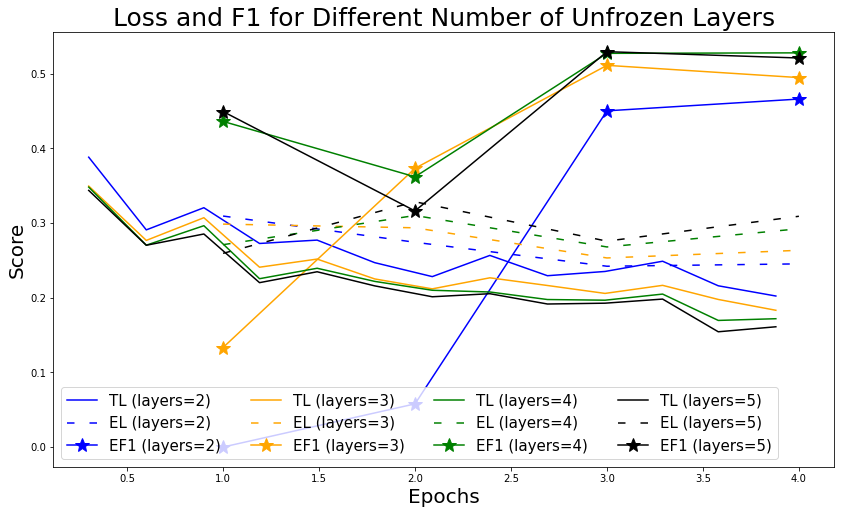

In [20]:
colors = {2: 'blue', 3: 'orange', 4: 'green', 5: 'black'}

plt.figure(figsize=(14, 8))
for layer, (train_loss, eval_loss, eval_f1) in results_n_layers.items():
    color = colors[layer]
    if len(train_loss) > 0:
        plt.plot(train_loss[:, 0], train_loss[:, 1],
                 label=f"TL (layers={layer})",
                 color=color, linestyle='-')
    if len(eval_loss) > 0:
        line, = plt.plot(eval_loss[:, 0], eval_loss[:, 1],
                 label=f"EL (layers={layer})",
                 color=color, linestyle='--')
        line.set_dashes([5, 10])
    if len(eval_f1) > 0:
        plt.plot(eval_f1[:, 0], eval_f1[:, 1],
                 label=f"EF1 (layers={layer})",
                 color=color, linestyle='-', marker='*', markersize=15)

plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.title("Loss and F1 for Different Number of Unfrozen Layers", fontsize=25)
plt.legend(prop={'size': 15}, ncol=4)
plt.show()


4 SLIGHTLY BETTER

### LEARNING RATE

In [24]:
# Testing lr in the base model
learning_rates = [1e-4, 1e-5, 1e-6]
results_lr = {}

for lr in learning_rates:
    print(f"Training with lr = {lr}")
    results_lr[lr] = train_and_collect_logs(lr, "learning_rate", train_dataset, eval_dataset)

Training with lr = 0.0001


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.3288, 'learning_rate': 9.256272401433693e-05, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:27, 19.23it/s]

{'loss': 0.2817, 'learning_rate': 8.512544802867384e-05, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:18, 18.75it/s]

{'loss': 0.3148, 'learning_rate': 7.765830346475508e-05, 'epoch': 0.9}


 25%|██▌       | 837/3348 [00:45<02:10, 19.19it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [00:51<02:10, 19.19it/s]Saving model checkpoint to ./results_learning_rate_0.0001/checkpoint-837
Configuration saved in ./results_learning_rate_0.0001/checkpoint-837/config.json


{'eval_loss': 0.2772882282733917, 'eval_f1': 0.4778761061946903, 'eval_runtime': 5.4138, 'eval_samples_per_second': 309.396, 'eval_steps_per_second': 77.395, 'epoch': 1.0}


Model weights saved in ./results_learning_rate_0.0001/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_0.0001/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_0.0001/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_learning_rate_0.0001/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:01<02:02, 19.22it/s]

{'loss': 0.2461, 'learning_rate': 7.019115890083633e-05, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:14<01:46, 19.65it/s]

{'loss': 0.2547, 'learning_rate': 6.272401433691756e-05, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:28<01:37, 18.84it/s]

{'loss': 0.2259, 'learning_rate': 5.525686977299881e-05, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:37<01:29, 18.75it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:42<01:29, 18.75it/s]Saving model checkpoint to ./results_learning_rate_0.0001/checkpoint-1674
Configuration saved in ./results_learning_rate_0.0001/checkpoint-1674/config.json


{'eval_loss': 0.3018513023853302, 'eval_f1': 0.3900414937759336, 'eval_runtime': 5.4519, 'eval_samples_per_second': 307.231, 'eval_steps_per_second': 76.854, 'epoch': 2.0}


Model weights saved in ./results_learning_rate_0.0001/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_0.0001/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_0.0001/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_learning_rate_0.0001/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:47<01:27, 18.29it/s]

{'loss': 0.219, 'learning_rate': 4.778972520908005e-05, 'epoch': 2.09}


 60%|█████▉    | 2002/3348 [02:01<01:09, 19.29it/s]

{'loss': 0.2067, 'learning_rate': 4.032258064516129e-05, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:14<01:01, 17.93it/s]

{'loss': 0.1765, 'learning_rate': 3.285543608124254e-05, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:28<00:43, 19.32it/s]

{'loss': 0.1914, 'learning_rate': 2.5388291517323774e-05, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:29<00:45, 18.56it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:34<00:45, 18.56it/s]Saving model checkpoint to ./results_learning_rate_0.0001/checkpoint-2511
Configuration saved in ./results_learning_rate_0.0001/checkpoint-2511/config.json


{'eval_loss': 0.2415647953748703, 'eval_f1': 0.49044585987261147, 'eval_runtime': 5.4738, 'eval_samples_per_second': 306.004, 'eval_steps_per_second': 76.547, 'epoch': 3.0}


Model weights saved in ./results_learning_rate_0.0001/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_0.0001/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_0.0001/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_learning_rate_0.0001/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2754/3348 [02:49<00:32, 18.23it/s]

{'loss': 0.1758, 'learning_rate': 1.7921146953405018e-05, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:02<00:17, 19.23it/s]

{'loss': 0.1481, 'learning_rate': 1.0454002389486262e-05, 'epoch': 3.58}


 97%|█████████▋| 3252/3348 [03:16<00:05, 18.99it/s]

{'loss': 0.1451, 'learning_rate': 3.0167264038231784e-06, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:21<00:00, 18.72it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:27<00:00, 18.72it/s]Saving model checkpoint to ./results_learning_rate_0.0001/checkpoint-3348
Configuration saved in ./results_learning_rate_0.0001/checkpoint-3348/config.json


{'eval_loss': 0.29936400055885315, 'eval_f1': 0.4507042253521127, 'eval_runtime': 5.498, 'eval_samples_per_second': 304.658, 'eval_steps_per_second': 76.21, 'epoch': 4.0}


Model weights saved in ./results_learning_rate_0.0001/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_0.0001/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_0.0001/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_learning_rate_0.0001/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_learning_rate_0.0001/checkpoint-2511 (score: 0.49044585987261147).
100%|██████████| 3348/3348 [03:28<00:00, 16.06it/s]


{'train_runtime': 208.5172, 'train_samples_per_second': 128.527, 'train_steps_per_second': 16.056, 'train_loss': 0.2218847636538452, 'epoch': 4.0}
Training with lr = 1e-05


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.3481, 'learning_rate': 9.256272401433693e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:25, 19.62it/s]

{'loss': 0.2704, 'learning_rate': 8.509557945041816e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:40<02:14, 19.26it/s]

{'loss': 0.2965, 'learning_rate': 7.765830346475508e-06, 'epoch': 0.9}


 25%|██▍       | 835/3348 [00:45<02:09, 19.39it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:50<02:09, 19.39it/s]Saving model checkpoint to ./results_learning_rate_1e-05/checkpoint-837
Configuration saved in ./results_learning_rate_1e-05/checkpoint-837/config.json


{'eval_loss': 0.27130770683288574, 'eval_f1': 0.43621399176954734, 'eval_runtime': 5.3954, 'eval_samples_per_second': 310.447, 'eval_steps_per_second': 77.658, 'epoch': 1.0}


Model weights saved in ./results_learning_rate_1e-05/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-05/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-05/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-05/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:00<02:03, 18.99it/s]

{'loss': 0.2256, 'learning_rate': 7.019115890083633e-06, 'epoch': 1.19}


 37%|███▋      | 1251/3348 [01:14<01:50, 18.95it/s]

{'loss': 0.2395, 'learning_rate': 6.272401433691757e-06, 'epoch': 1.49}


 45%|████▍     | 1502/3348 [01:28<01:39, 18.62it/s]

{'loss': 0.222, 'learning_rate': 5.525686977299881e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:37<01:30, 18.49it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:42<01:30, 18.49it/s]Saving model checkpoint to ./results_learning_rate_1e-05/checkpoint-1674
Configuration saved in ./results_learning_rate_1e-05/checkpoint-1674/config.json


{'eval_loss': 0.31036853790283203, 'eval_f1': 0.36199095022624433, 'eval_runtime': 5.4642, 'eval_samples_per_second': 306.543, 'eval_steps_per_second': 76.682, 'epoch': 2.0}


Model weights saved in ./results_learning_rate_1e-05/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-05/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-05/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-05/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1753/3348 [01:48<01:29, 17.82it/s]

{'loss': 0.21, 'learning_rate': 4.7789725209080055e-06, 'epoch': 2.09}


 60%|█████▉    | 2002/3348 [02:01<01:09, 19.25it/s]

{'loss': 0.2077, 'learning_rate': 4.032258064516129e-06, 'epoch': 2.39}


 67%|██████▋   | 2252/3348 [02:14<00:59, 18.51it/s]

{'loss': 0.1977, 'learning_rate': 3.2855436081242537e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:29<00:45, 18.74it/s]

{'loss': 0.1967, 'learning_rate': 2.538829151732378e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:29<00:45, 18.53it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:35<00:45, 18.53it/s]Saving model checkpoint to ./results_learning_rate_1e-05/checkpoint-2511
Configuration saved in ./results_learning_rate_1e-05/checkpoint-2511/config.json


{'eval_loss': 0.26808133721351624, 'eval_f1': 0.5273972602739726, 'eval_runtime': 5.5375, 'eval_samples_per_second': 302.481, 'eval_steps_per_second': 75.665, 'epoch': 3.0}


Model weights saved in ./results_learning_rate_1e-05/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-05/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-05/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-05/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2751/3348 [02:49<00:34, 17.11it/s]

{'loss': 0.2049, 'learning_rate': 1.7951015531660695e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:03<00:17, 19.44it/s]

{'loss': 0.1697, 'learning_rate': 1.0483870967741936e-06, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:16<00:05, 18.67it/s]

{'loss': 0.172, 'learning_rate': 3.0465949820788535e-07, 'epoch': 3.88}


100%|██████████| 3348/3348 [03:21<00:00, 18.91it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:27<00:00, 18.91it/s]Saving model checkpoint to ./results_learning_rate_1e-05/checkpoint-3348
Configuration saved in ./results_learning_rate_1e-05/checkpoint-3348/config.json


{'eval_loss': 0.2924209535121918, 'eval_f1': 0.5280528052805281, 'eval_runtime': 5.4063, 'eval_samples_per_second': 309.822, 'eval_steps_per_second': 77.502, 'epoch': 4.0}


Model weights saved in ./results_learning_rate_1e-05/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-05/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-05/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-05/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_learning_rate_1e-05/checkpoint-3348 (score: 0.5280528052805281).
100%|██████████| 3348/3348 [03:28<00:00, 16.05it/s]


{'train_runtime': 208.6561, 'train_samples_per_second': 128.441, 'train_steps_per_second': 16.046, 'train_loss': 0.22598816929752255, 'epoch': 4.0}
Training with lr = 1e-06


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.5139, 'learning_rate': 9.253285543608124e-07, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:27, 19.30it/s]

{'loss': 0.3315, 'learning_rate': 8.506571087216248e-07, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:18, 18.78it/s]

{'loss': 0.3307, 'learning_rate': 7.762843488649939e-07, 'epoch': 0.9}


 25%|██▍       | 835/3348 [00:45<02:09, 19.39it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:51<02:09, 19.39it/s]Saving model checkpoint to ./results_learning_rate_1e-06/checkpoint-837
Configuration saved in ./results_learning_rate_1e-06/checkpoint-837/config.json


{'eval_loss': 0.32668957114219666, 'eval_f1': 0.0, 'eval_runtime': 5.4536, 'eval_samples_per_second': 307.138, 'eval_steps_per_second': 76.83, 'epoch': 1.0}


Model weights saved in ./results_learning_rate_1e-06/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-06/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-06/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-06/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:01<01:58, 19.78it/s]

{'loss': 0.2993, 'learning_rate': 7.016129032258065e-07, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:14<01:46, 19.63it/s]

{'loss': 0.3228, 'learning_rate': 6.269414575866188e-07, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:28<01:39, 18.49it/s]

{'loss': 0.298, 'learning_rate': 5.52568697729988e-07, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:37<01:30, 18.46it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:43<01:30, 18.46it/s]Saving model checkpoint to ./results_learning_rate_1e-06/checkpoint-1674
Configuration saved in ./results_learning_rate_1e-06/checkpoint-1674/config.json


{'eval_loss': 0.31218239665031433, 'eval_f1': 0.0, 'eval_runtime': 5.4678, 'eval_samples_per_second': 306.337, 'eval_steps_per_second': 76.63, 'epoch': 2.0}


Model weights saved in ./results_learning_rate_1e-06/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-06/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-06/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-06/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1753/3348 [01:48<01:29, 17.74it/s]

{'loss': 0.2862, 'learning_rate': 4.778972520908004e-07, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:01<01:11, 18.81it/s]

{'loss': 0.3161, 'learning_rate': 4.0322580645161285e-07, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:15<00:59, 18.30it/s]

{'loss': 0.296, 'learning_rate': 3.285543608124253e-07, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:29<00:46, 18.27it/s]

{'loss': 0.2965, 'learning_rate': 2.5388291517323775e-07, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:30<00:45, 18.54it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:35<00:45, 18.54it/s]Saving model checkpoint to ./results_learning_rate_1e-06/checkpoint-2511
Configuration saved in ./results_learning_rate_1e-06/checkpoint-2511/config.json


{'eval_loss': 0.3019915223121643, 'eval_f1': 0.0, 'eval_runtime': 5.4859, 'eval_samples_per_second': 305.328, 'eval_steps_per_second': 76.378, 'epoch': 3.0}


Model weights saved in ./results_learning_rate_1e-06/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-06/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-06/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-06/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [02:50<00:33, 18.01it/s]

{'loss': 0.3094, 'learning_rate': 1.7921146953405018e-07, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:04<00:18, 18.32it/s]

{'loss': 0.2874, 'learning_rate': 1.0454002389486261e-07, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:17<00:05, 18.63it/s]

{'loss': 0.2849, 'learning_rate': 2.986857825567503e-08, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:22<00:00, 18.93it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:28<00:00, 18.93it/s]Saving model checkpoint to ./results_learning_rate_1e-06/checkpoint-3348
Configuration saved in ./results_learning_rate_1e-06/checkpoint-3348/config.json


{'eval_loss': 0.3008498549461365, 'eval_f1': 0.0, 'eval_runtime': 5.4919, 'eval_samples_per_second': 304.993, 'eval_steps_per_second': 76.294, 'epoch': 4.0}


Model weights saved in ./results_learning_rate_1e-06/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_learning_rate_1e-06/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_learning_rate_1e-06/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_learning_rate_1e-06/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_learning_rate_1e-06/checkpoint-837 (score: 0.0).
100%|██████████| 3348/3348 [03:29<00:00, 15.96it/s]

{'train_runtime': 209.7399, 'train_samples_per_second': 127.777, 'train_steps_per_second': 15.963, 'train_loss': 0.32050354762743877, 'epoch': 4.0}


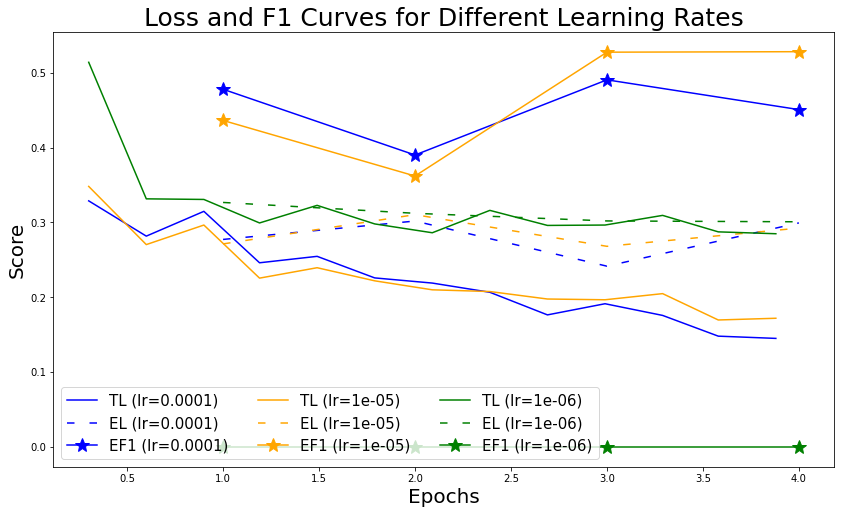

In [25]:
colors = {1e-4: 'blue', 1e-5: 'orange', 1e-6: 'green'}

plt.figure(figsize=(14, 8))
for lr, (train_loss, eval_loss, eval_f1) in results_lr.items():
    color = colors[lr]
    if len(train_loss) > 0:
        plt.plot(train_loss[:, 0], train_loss[:, 1],
                 label=f"TL (lr={lr})",
                 color=color, linestyle='-')
    if len(eval_loss) > 0:
        line, = plt.plot(eval_loss[:, 0], eval_loss[:, 1],
                 label=f"EL (lr={lr})",
                 color=color, linestyle='--')
        line.set_dashes([5, 10])
    if len(eval_f1) > 0:
        plt.plot(eval_f1[:, 0], eval_f1[:, 1],
                 label=f"EF1 (lr={lr})",
                 color=color, linestyle='-', marker='*', markersize=15)

plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.title("Loss and F1 Curves for Different Learning Rates", fontsize=25)

plt.legend(prop={'size': 15}, ncol=3, loc='lower left')
plt.show()


### LEARNING SCHEDULE

In [13]:
# Testing the learning schedule in the base model
schedules = ["cosine", "polynomial", "linear"]
results_schedules = {}

for schedule in schedules:
    print(f"Training with schedule = {schedule}")
    results_schedules[schedule] = train_and_collect_logs(schedule, "learning_schedule", train_dataset, eval_dataset)

Training with schedule = cosine


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

{'loss': 0.5282, 'learning_rate': 5e-06, 'epoch': 0.3}


 15%|█▍        | 501/3348 [00:27<02:24, 19.77it/s]

{'loss': 0.2973, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:19, 18.56it/s]

{'loss': 0.3158, 'learning_rate': 9.814068500813692e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [00:45<02:12, 18.91it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:51<02:12, 18.91it/s]Saving model checkpoint to ./results_learning_schedule_cosine/checkpoint-837
Configuration saved in ./results_learning_schedule_cosine/checkpoint-837/config.json


{'eval_loss': 0.28501471877098083, 'eval_f1': 0.11235955056179775, 'eval_runtime': 5.4484, 'eval_samples_per_second': 307.431, 'eval_steps_per_second': 76.904, 'epoch': 1.0}


Model weights saved in ./results_learning_schedule_cosine/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_cosine/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_cosine/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_cosine/checkpoint-837/added_tokens.json
 30%|██▉       | 1004/3348 [01:01<01:57, 20.02it/s]

{'loss': 0.2348, 'learning_rate': 9.264353129806016e-06, 'epoch': 1.19}


 37%|███▋      | 1252/3348 [01:15<01:49, 19.09it/s]

{'loss': 0.2542, 'learning_rate': 8.392383353650463e-06, 'epoch': 1.49}


 45%|████▍     | 1502/3348 [01:28<01:37, 18.95it/s]

{'loss': 0.2185, 'learning_rate': 7.264053363791423e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:38<01:29, 18.67it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:43<01:29, 18.67it/s]Saving model checkpoint to ./results_learning_schedule_cosine/checkpoint-1674
Configuration saved in ./results_learning_schedule_cosine/checkpoint-1674/config.json


{'eval_loss': 0.27620038390159607, 'eval_f1': 0.3876651982378855, 'eval_runtime': 5.4845, 'eval_samples_per_second': 305.404, 'eval_steps_per_second': 76.397, 'epoch': 2.0}


Model weights saved in ./results_learning_schedule_cosine/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_cosine/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_cosine/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_cosine/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:49<01:27, 18.21it/s]

{'loss': 0.2048, 'learning_rate': 5.964630327047485e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:02<01:10, 19.12it/s]

{'loss': 0.2119, 'learning_rate': 4.592310801019502e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:16<01:01, 17.77it/s]

{'loss': 0.1965, 'learning_rate': 3.250800083808121e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:30<00:44, 18.85it/s]

{'loss': 0.2055, 'learning_rate': 2.041475271778279e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:30<00:42, 19.53it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:36<00:42, 19.53it/s]Saving model checkpoint to ./results_learning_schedule_cosine/checkpoint-2511
Configuration saved in ./results_learning_schedule_cosine/checkpoint-2511/config.json


{'eval_loss': 0.26025134325027466, 'eval_f1': 0.5238095238095238, 'eval_runtime': 5.4762, 'eval_samples_per_second': 305.87, 'eval_steps_per_second': 76.513, 'epoch': 3.0}


Model weights saved in ./results_learning_schedule_cosine/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_cosine/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_cosine/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_cosine/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2754/3348 [02:51<00:31, 18.78it/s]

{'loss': 0.2054, 'learning_rate': 1.0557242580215066e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:04<00:17, 19.58it/s]

{'loss': 0.1648, 'learning_rate': 3.7011932097025083e-07, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:17<00:05, 18.23it/s]

{'loss': 0.1657, 'learning_rate': 3.0999397889895365e-08, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:23<00:00, 19.04it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:28<00:00, 19.04it/s]Saving model checkpoint to ./results_learning_schedule_cosine/checkpoint-3348
Configuration saved in ./results_learning_schedule_cosine/checkpoint-3348/config.json


{'eval_loss': 0.27667927742004395, 'eval_f1': 0.5423728813559322, 'eval_runtime': 5.5934, 'eval_samples_per_second': 299.462, 'eval_steps_per_second': 74.91, 'epoch': 4.0}


Model weights saved in ./results_learning_schedule_cosine/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_cosine/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_cosine/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_cosine/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_learning_schedule_cosine/checkpoint-3348 (score: 0.5423728813559322).
100%|██████████| 3348/3348 [03:30<00:00, 15.89it/s]


{'train_runtime': 210.648, 'train_samples_per_second': 127.226, 'train_steps_per_second': 15.894, 'train_loss': 0.2438788132000995, 'epoch': 4.0}
Training with schedule = polynomial


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:25, 19.55it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 752/3348 [00:40<02:25, 17.87it/s]

{'loss': 0.3077, 'learning_rate': 9.134445224719101e-06, 'epoch': 0.9}


 25%|██▌       | 837/3348 [00:45<02:11, 19.11it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [00:51<02:11, 19.11it/s]Saving model checkpoint to ./results_learning_schedule_polynomial/checkpoint-837
Configuration saved in ./results_learning_schedule_polynomial/checkpoint-837/config.json


{'eval_loss': 0.2693988084793091, 'eval_f1': 0.2105263157894737, 'eval_runtime': 5.4299, 'eval_samples_per_second': 308.475, 'eval_steps_per_second': 77.165, 'epoch': 1.0}


Model weights saved in ./results_learning_schedule_polynomial/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_polynomial/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_polynomial/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_polynomial/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:01<02:04, 18.92it/s]

{'loss': 0.2305, 'learning_rate': 8.265414325842698e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:14<01:48, 19.23it/s]

{'loss': 0.244, 'learning_rate': 7.399859550561797e-06, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:28<01:37, 18.83it/s]

{'loss': 0.2226, 'learning_rate': 6.530828651685393e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:37<01:29, 18.70it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:43<01:29, 18.70it/s]Saving model checkpoint to ./results_learning_schedule_polynomial/checkpoint-1674
Configuration saved in ./results_learning_schedule_polynomial/checkpoint-1674/config.json


{'eval_loss': 0.29275208711624146, 'eval_f1': 0.35348837209302325, 'eval_runtime': 5.4438, 'eval_samples_per_second': 307.689, 'eval_steps_per_second': 76.968, 'epoch': 2.0}


Model weights saved in ./results_learning_schedule_polynomial/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_polynomial/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_polynomial/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_polynomial/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1753/3348 [01:48<01:27, 18.26it/s]

{'loss': 0.2119, 'learning_rate': 5.661797752808989e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:01<01:12, 18.53it/s]

{'loss': 0.2074, 'learning_rate': 4.792766853932584e-06, 'epoch': 2.39}


 67%|██████▋   | 2252/3348 [02:15<01:00, 18.05it/s]

{'loss': 0.1941, 'learning_rate': 3.927212078651685e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:29<00:44, 18.99it/s]

{'loss': 0.1973, 'learning_rate': 3.058181179775281e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:29<00:47, 17.49it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:35<00:47, 17.49it/s]Saving model checkpoint to ./results_learning_schedule_polynomial/checkpoint-2511
Configuration saved in ./results_learning_schedule_polynomial/checkpoint-2511/config.json


{'eval_loss': 0.2554214894771576, 'eval_f1': 0.5135135135135136, 'eval_runtime': 5.4028, 'eval_samples_per_second': 310.024, 'eval_steps_per_second': 77.552, 'epoch': 3.0}


Model weights saved in ./results_learning_schedule_polynomial/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_polynomial/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_polynomial/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_polynomial/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [02:50<00:32, 18.23it/s]

{'loss': 0.1976, 'learning_rate': 2.1891502808988762e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:03<00:17, 19.47it/s]

{'loss': 0.1621, 'learning_rate': 1.320119382022472e-06, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:16<00:04, 19.42it/s]

{'loss': 0.1677, 'learning_rate': 4.510884831460673e-07, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:21<00:00, 18.99it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:27<00:00, 18.99it/s]Saving model checkpoint to ./results_learning_schedule_polynomial/checkpoint-3348
Configuration saved in ./results_learning_schedule_polynomial/checkpoint-3348/config.json


{'eval_loss': 0.2845929265022278, 'eval_f1': 0.5159235668789809, 'eval_runtime': 5.4139, 'eval_samples_per_second': 309.389, 'eval_steps_per_second': 77.394, 'epoch': 4.0}


Model weights saved in ./results_learning_schedule_polynomial/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_polynomial/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_polynomial/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_polynomial/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_learning_schedule_polynomial/checkpoint-3348 (score: 0.5159235668789809).
100%|██████████| 3348/3348 [03:29<00:00, 16.01it/s]


{'train_runtime': 209.1853, 'train_samples_per_second': 128.116, 'train_steps_per_second': 16.005, 'train_loss': 0.23668134853404055, 'epoch': 4.0}
Training with schedule = linear


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▍        | 502/3348 [00:27<02:27, 19.28it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:18, 18.71it/s]

{'loss': 0.3077, 'learning_rate': 9.125702247191011e-06, 'epoch': 0.9}


 25%|██▌       | 837/3348 [00:46<02:08, 19.57it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [00:51<02:08, 19.57it/s]Saving model checkpoint to ./results_learning_schedule_linear/checkpoint-837
Configuration saved in ./results_learning_schedule_linear/checkpoint-837/config.json


{'eval_loss': 0.269390732049942, 'eval_f1': 0.2105263157894737, 'eval_runtime': 5.4338, 'eval_samples_per_second': 308.258, 'eval_steps_per_second': 77.11, 'epoch': 1.0}


Model weights saved in ./results_learning_schedule_linear/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_linear/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_linear/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_linear/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:01<02:05, 18.70it/s]

{'loss': 0.2305, 'learning_rate': 8.247893258426967e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:15<01:50, 18.97it/s]

{'loss': 0.244, 'learning_rate': 7.373595505617978e-06, 'epoch': 1.49}


 45%|████▍     | 1502/3348 [01:29<01:39, 18.65it/s]

{'loss': 0.2226, 'learning_rate': 6.495786516853933e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:38<01:29, 18.68it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:43<01:29, 18.68it/s]Saving model checkpoint to ./results_learning_schedule_linear/checkpoint-1674
Configuration saved in ./results_learning_schedule_linear/checkpoint-1674/config.json


{'eval_loss': 0.2926781177520752, 'eval_f1': 0.35348837209302325, 'eval_runtime': 5.4178, 'eval_samples_per_second': 309.164, 'eval_steps_per_second': 77.337, 'epoch': 2.0}


Model weights saved in ./results_learning_schedule_linear/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_linear/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_linear/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_linear/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:49<01:27, 18.16it/s]

{'loss': 0.2118, 'learning_rate': 5.617977528089889e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:02<01:11, 18.75it/s]

{'loss': 0.2074, 'learning_rate': 4.740168539325843e-06, 'epoch': 2.39}


 67%|██████▋   | 2252/3348 [02:16<00:59, 18.32it/s]

{'loss': 0.1941, 'learning_rate': 3.865870786516855e-06, 'epoch': 2.69}


 75%|███████▍  | 2503/3348 [02:30<00:43, 19.33it/s]

{'loss': 0.1972, 'learning_rate': 2.988061797752809e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:30<00:46, 17.93it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 75%|███████▌  | 2511/3348 [02:36<00:46, 17.93it/s]Saving model checkpoint to ./results_learning_schedule_linear/checkpoint-2511
Configuration saved in ./results_learning_schedule_linear/checkpoint-2511/config.json


{'eval_loss': 0.25531432032585144, 'eval_f1': 0.5135135135135136, 'eval_runtime': 5.4097, 'eval_samples_per_second': 309.63, 'eval_steps_per_second': 77.454, 'epoch': 3.0}


Model weights saved in ./results_learning_schedule_linear/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_linear/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_linear/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_linear/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2751/3348 [02:51<00:35, 17.01it/s]

{'loss': 0.1978, 'learning_rate': 2.1102528089887643e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:05<00:17, 19.30it/s]

{'loss': 0.1621, 'learning_rate': 1.2324438202247193e-06, 'epoch': 3.58}


 97%|█████████▋| 3252/3348 [03:18<00:04, 19.44it/s]

{'loss': 0.1674, 'learning_rate': 3.546348314606742e-07, 'epoch': 3.88}


100%|██████████| 3348/3348 [03:23<00:00, 19.19it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:28<00:00, 19.19it/s]Saving model checkpoint to ./results_learning_schedule_linear/checkpoint-3348
Configuration saved in ./results_learning_schedule_linear/checkpoint-3348/config.json


{'eval_loss': 0.28387266397476196, 'eval_f1': 0.5128205128205128, 'eval_runtime': 5.4213, 'eval_samples_per_second': 308.969, 'eval_steps_per_second': 77.288, 'epoch': 4.0}


Model weights saved in ./results_learning_schedule_linear/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_learning_schedule_linear/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_learning_schedule_linear/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_learning_schedule_linear/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_learning_schedule_linear/checkpoint-2511 (score: 0.5135135135135136).
100%|██████████| 3348/3348 [03:30<00:00, 15.90it/s]

{'train_runtime': 210.623, 'train_samples_per_second': 127.242, 'train_steps_per_second': 15.896, 'train_loss': 0.23667373566074895, 'epoch': 4.0}


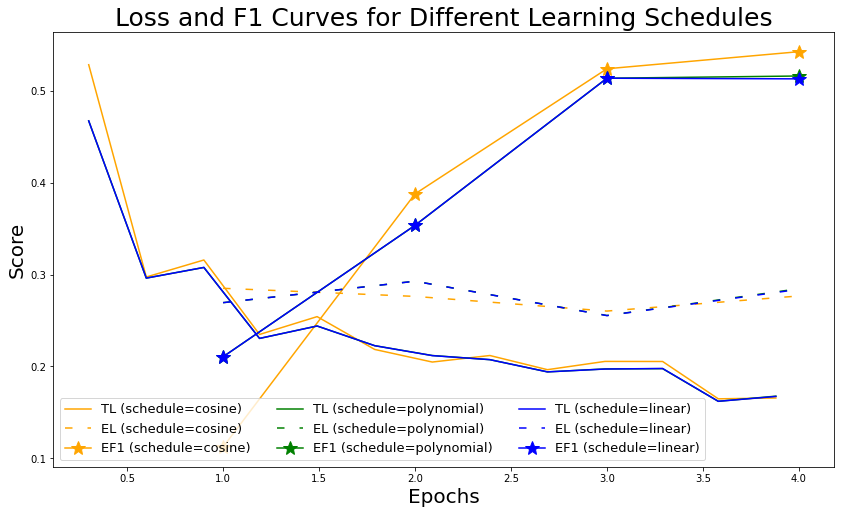

In [14]:
colors = {"linear": 'blue', "cosine": 'orange', "polynomial": 'green'}

plt.figure(figsize=(14, 8))
for schedule, (train_loss, eval_loss, eval_f1) in results_schedules.items():
    color = colors[schedule]
    if len(train_loss) > 0:
        plt.plot(train_loss[:, 0], train_loss[:, 1],
                 label=f"TL (schedule={schedule})",
                 color=color, linestyle='-')
    if len(eval_loss) > 0:
        line, = plt.plot(eval_loss[:, 0], eval_loss[:, 1],
                 label=f"EL (schedule={schedule})",
                 color=color, linestyle='--')
        line.set_dashes([5, 10])
    if len(eval_f1) > 0:
        plt.plot(eval_f1[:, 0], eval_f1[:, 1],
                 label=f"EF1 (schedule={schedule})",
                 color=color, linestyle='-', marker='*', markersize=15)

plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.title("Loss and F1 Curves for Different Learning Schedules", fontsize=25)
plt.legend(prop={'size': 13}, ncol=3, loc='lower left')
plt.show()


### WEIGHT DECAY

In [27]:
# Testing weight decay in the base model
w_decay = [0.02, 0.05, 0.1]
results_w_decay = {}

for decay in w_decay:
    print(f"Training with weight decay = {decay}")
    results_w_decay[decay] = train_and_collect_logs(decay, "weight_decay", train_dataset, eval_dataset)

Training with weight decay = 0.02


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:24, 19.75it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:22, 18.28it/s]

{'loss': 0.3078, 'learning_rate': 9.812575487669263e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [00:45<02:12, 18.95it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [00:51<02:12, 18.95it/s]Saving model checkpoint to ./results_weight_decay_0.02/checkpoint-837
Configuration saved in ./results_weight_decay_0.02/checkpoint-837/config.json


{'eval_loss': 0.2680451571941376, 'eval_f1': 0.2105263157894737, 'eval_runtime': 5.4972, 'eval_samples_per_second': 304.703, 'eval_steps_per_second': 76.221, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.02/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.02/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.02/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.02/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:01<02:00, 19.46it/s]

{'loss': 0.2315, 'learning_rate': 9.26147080354642e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:15<01:48, 19.30it/s]

{'loss': 0.2457, 'learning_rate': 8.392383353650463e-06, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:29<01:37, 18.95it/s]

{'loss': 0.2228, 'learning_rate': 7.264053363791423e-06, 'epoch': 1.79}


 50%|████▉     | 1673/3348 [01:38<01:30, 18.42it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:44<01:30, 18.42it/s]Saving model checkpoint to ./results_weight_decay_0.02/checkpoint-1674
Configuration saved in ./results_weight_decay_0.02/checkpoint-1674/config.json


{'eval_loss': 0.2933272421360016, 'eval_f1': 0.34579439252336447, 'eval_runtime': 5.5666, 'eval_samples_per_second': 300.901, 'eval_steps_per_second': 75.27, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.02/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.02/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.02/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.02/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:50<01:29, 17.93it/s]

{'loss': 0.2111, 'learning_rate': 5.964630327047485e-06, 'epoch': 2.09}


 60%|█████▉    | 2002/3348 [02:03<01:09, 19.40it/s]

{'loss': 0.2048, 'learning_rate': 4.592310801019502e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:17<01:01, 17.86it/s]

{'loss': 0.1912, 'learning_rate': 3.2559680601662887e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:31<00:44, 18.97it/s]

{'loss': 0.1934, 'learning_rate': 2.0459233654457707e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:32<00:44, 18.66it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 75%|███████▌  | 2511/3348 [02:37<00:44, 18.66it/s]Saving model checkpoint to ./results_weight_decay_0.02/checkpoint-2511
Configuration saved in ./results_weight_decay_0.02/checkpoint-2511/config.json


{'eval_loss': 0.2555476725101471, 'eval_f1': 0.5135135135135136, 'eval_runtime': 5.5729, 'eval_samples_per_second': 300.56, 'eval_steps_per_second': 75.185, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.02/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.02/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.02/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.02/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2754/3348 [02:53<00:32, 18.45it/s]

{'loss': 0.1948, 'learning_rate': 1.0591163294397e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:06<00:17, 19.27it/s]

{'loss': 0.1585, 'learning_rate': 3.7011932097025083e-07, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:20<00:05, 18.34it/s]

{'loss': 0.1577, 'learning_rate': 3.0999397889895365e-08, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:25<00:00, 19.23it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:30<00:00, 19.23it/s]Saving model checkpoint to ./results_weight_decay_0.02/checkpoint-3348
Configuration saved in ./results_weight_decay_0.02/checkpoint-3348/config.json


{'eval_loss': 0.27386659383773804, 'eval_f1': 0.508361204013378, 'eval_runtime': 5.5529, 'eval_samples_per_second': 301.647, 'eval_steps_per_second': 75.457, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.02/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.02/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.02/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.02/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.02/checkpoint-2511 (score: 0.5135135135135136).
100%|██████████| 3348/3348 [03:32<00:00, 15.73it/s]


{'train_runtime': 212.8228, 'train_samples_per_second': 125.926, 'train_steps_per_second': 15.731, 'train_loss': 0.23485494713914296, 'epoch': 4.0}
Training with weight decay = 0.05


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:33, 18.56it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:26, 17.69it/s]

{'loss': 0.3078, 'learning_rate': 9.812575487669263e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [00:46<02:14, 18.71it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:52<02:14, 18.71it/s]Saving model checkpoint to ./results_weight_decay_0.05/checkpoint-837
Configuration saved in ./results_weight_decay_0.05/checkpoint-837/config.json


{'eval_loss': 0.26796966791152954, 'eval_f1': 0.2105263157894737, 'eval_runtime': 5.6245, 'eval_samples_per_second': 297.807, 'eval_steps_per_second': 74.496, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.05/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.05/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.05/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.05/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:02<02:02, 19.15it/s]

{'loss': 0.2315, 'learning_rate': 9.26147080354642e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:16<01:53, 18.38it/s]

{'loss': 0.2458, 'learning_rate': 8.392383353650463e-06, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:30<01:39, 18.59it/s]

{'loss': 0.2228, 'learning_rate': 7.264053363791423e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:39<01:31, 18.38it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:44<01:31, 18.38it/s]Saving model checkpoint to ./results_weight_decay_0.05/checkpoint-1674
Configuration saved in ./results_weight_decay_0.05/checkpoint-1674/config.json


{'eval_loss': 0.29302895069122314, 'eval_f1': 0.34579439252336447, 'eval_runtime': 5.6338, 'eval_samples_per_second': 297.312, 'eval_steps_per_second': 74.372, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.05/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.05/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.05/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.05/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [01:50<01:31, 17.35it/s]

{'loss': 0.2111, 'learning_rate': 5.964630327047485e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:03<01:10, 19.05it/s]

{'loss': 0.2048, 'learning_rate': 4.592310801019502e-06, 'epoch': 2.39}


 67%|██████▋   | 2252/3348 [02:17<01:00, 18.16it/s]

{'loss': 0.1912, 'learning_rate': 3.2559680601662887e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:31<00:44, 18.96it/s]

{'loss': 0.1935, 'learning_rate': 2.0459233654457707e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:32<00:47, 17.62it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:38<00:47, 17.62it/s]Saving model checkpoint to ./results_weight_decay_0.05/checkpoint-2511
Configuration saved in ./results_weight_decay_0.05/checkpoint-2511/config.json


{'eval_loss': 0.2554863393306732, 'eval_f1': 0.5135135135135136, 'eval_runtime': 5.6587, 'eval_samples_per_second': 296.006, 'eval_steps_per_second': 74.046, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.05/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.05/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.05/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.05/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2754/3348 [02:52<00:31, 18.94it/s]

{'loss': 0.1948, 'learning_rate': 1.0591163294397e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:06<00:18, 19.16it/s]

{'loss': 0.1585, 'learning_rate': 3.7011932097025083e-07, 'epoch': 3.58}


 97%|█████████▋| 3252/3348 [03:19<00:04, 19.60it/s]

{'loss': 0.1578, 'learning_rate': 3.0999397889895365e-08, 'epoch': 3.88}


100%|██████████| 3348/3348 [03:24<00:00, 19.29it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:30<00:00, 19.29it/s]Saving model checkpoint to ./results_weight_decay_0.05/checkpoint-3348
Configuration saved in ./results_weight_decay_0.05/checkpoint-3348/config.json


{'eval_loss': 0.27380943298339844, 'eval_f1': 0.508361204013378, 'eval_runtime': 5.4456, 'eval_samples_per_second': 307.59, 'eval_steps_per_second': 76.943, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.05/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.05/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.05/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.05/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.05/checkpoint-2511 (score: 0.5135135135135136).
100%|██████████| 3348/3348 [03:31<00:00, 15.83it/s]


{'train_runtime': 211.5473, 'train_samples_per_second': 126.686, 'train_steps_per_second': 15.826, 'train_loss': 0.2348704617225711, 'epoch': 4.0}
Training with weight decay = 0.1


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:29, 18.99it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:18, 18.80it/s]

{'loss': 0.3078, 'learning_rate': 9.812575487669263e-06, 'epoch': 0.9}


 25%|██▍       | 835/3348 [00:46<02:10, 19.32it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [00:51<02:09, 19.32it/s]Saving model checkpoint to ./results_weight_decay_0.1/checkpoint-837
Configuration saved in ./results_weight_decay_0.1/checkpoint-837/config.json


{'eval_loss': 0.26800230145454407, 'eval_f1': 0.2105263157894737, 'eval_runtime': 5.4668, 'eval_samples_per_second': 306.396, 'eval_steps_per_second': 76.645, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.1/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.1/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.1/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.1/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:01<01:59, 19.58it/s]

{'loss': 0.2316, 'learning_rate': 9.26147080354642e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:15<01:48, 19.37it/s]

{'loss': 0.2457, 'learning_rate': 8.392383353650463e-06, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:29<01:38, 18.77it/s]

{'loss': 0.2227, 'learning_rate': 7.264053363791423e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:38<01:32, 18.12it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:43<01:32, 18.12it/s]Saving model checkpoint to ./results_weight_decay_0.1/checkpoint-1674
Configuration saved in ./results_weight_decay_0.1/checkpoint-1674/config.json


{'eval_loss': 0.2930695712566376, 'eval_f1': 0.34579439252336447, 'eval_runtime': 5.4373, 'eval_samples_per_second': 308.06, 'eval_steps_per_second': 77.061, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.1/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.1/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.1/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.1/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1753/3348 [01:48<01:29, 17.82it/s]

{'loss': 0.2112, 'learning_rate': 5.964630327047485e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:02<01:14, 18.07it/s]

{'loss': 0.2049, 'learning_rate': 4.592310801019502e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:16<01:01, 17.84it/s]

{'loss': 0.1912, 'learning_rate': 3.2559680601662887e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:30<00:46, 18.17it/s]

{'loss': 0.1936, 'learning_rate': 2.0459233654457707e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:31<00:45, 18.49it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 75%|███████▌  | 2511/3348 [02:36<00:45, 18.49it/s]Saving model checkpoint to ./results_weight_decay_0.1/checkpoint-2511
Configuration saved in ./results_weight_decay_0.1/checkpoint-2511/config.json


{'eval_loss': 0.2553979754447937, 'eval_f1': 0.5135135135135136, 'eval_runtime': 5.5928, 'eval_samples_per_second': 299.492, 'eval_steps_per_second': 74.918, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.1/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.1/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.1/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.1/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [02:51<00:33, 17.81it/s]

{'loss': 0.1949, 'learning_rate': 1.0591163294397e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:04<00:17, 19.45it/s]

{'loss': 0.1586, 'learning_rate': 3.7011932097025083e-07, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:18<00:05, 18.72it/s]

{'loss': 0.1579, 'learning_rate': 3.0999397889895365e-08, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:23<00:00, 19.18it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:29<00:00, 19.18it/s]Saving model checkpoint to ./results_weight_decay_0.1/checkpoint-3348
Configuration saved in ./results_weight_decay_0.1/checkpoint-3348/config.json


{'eval_loss': 0.2736741006374359, 'eval_f1': 0.508361204013378, 'eval_runtime': 5.4585, 'eval_samples_per_second': 306.859, 'eval_steps_per_second': 76.76, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.1/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.1/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.1/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.1/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.1/checkpoint-2511 (score: 0.5135135135135136).
100%|██████████| 3348/3348 [03:30<00:00, 15.92it/s]

{'train_runtime': 210.3615, 'train_samples_per_second': 127.4, 'train_steps_per_second': 15.915, 'train_loss': 0.23489879764251526, 'epoch': 4.0}


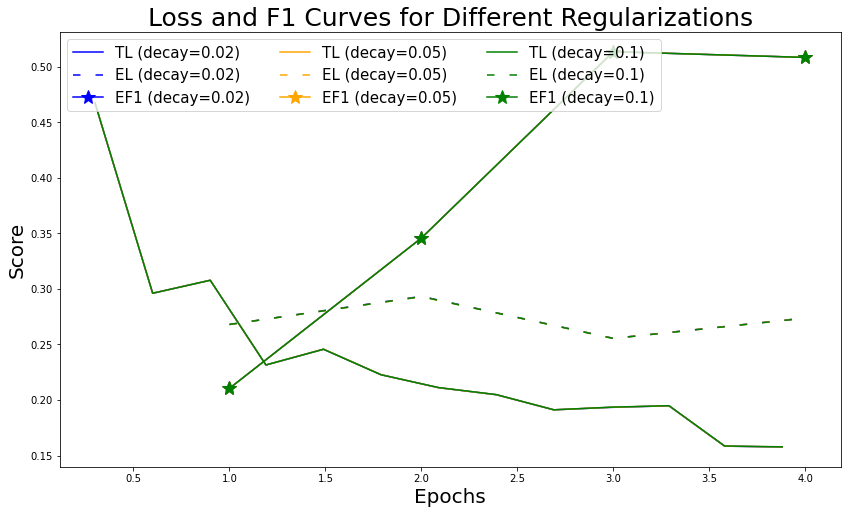

In [31]:
colors = {0.02: 'blue', 0.05: 'orange', 0.1: 'green'}

plt.figure(figsize=(14, 8))
for decay, (train_loss, eval_loss, eval_f1) in results_w_decay.items():
    color = colors[decay]
    if len(train_loss) > 0:
        plt.plot(train_loss[:, 0], train_loss[:, 1],
                 label=f"TL (decay={decay})",
                 color=color, linestyle='-')
    if len(eval_loss) > 0:
        line, = plt.plot(eval_loss[:, 0], eval_loss[:, 1],
                 label=f"EL (decay={decay})",
                 color=color, linestyle='--')
        line.set_dashes([5, 10])
    if len(eval_f1) > 0:
        plt.plot(eval_f1[:, 0], eval_f1[:, 1],
                 label=f"EF1 (decay={decay})",
                 color=color, linestyle='-', marker='*', markersize=15)

plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.title("Loss and F1 Curves for Different Regularizations", fontsize=25)
plt.legend(prop={'size': 15}, ncol=3, loc='upper left')
plt.show()


In [22]:
train_loss

array([[0.3   , 0.3481],
       [0.6   , 0.2704],
       [0.9   , 0.2965],
       [1.19  , 0.2256],
       [1.49  , 0.2395],
       [1.79  , 0.2219],
       [2.09  , 0.21  ],
       [2.39  , 0.2077],
       [2.69  , 0.1976],
       [2.99  , 0.1967],
       [3.29  , 0.2047],
       [3.58  , 0.1695],
       [3.88  , 0.1722]])

### Final model CASED VS UNCASED

In [16]:
tokenizer.do_lower_case

False

- Our model is CASED
- We convert out data to uncased to test how it works, but we can anticipate that this should not work, since we are taking valuable information out from to the model.

In [32]:
# Convert text features to lowercase
train_uncased = pd.read_csv('data/train.csv', index_col=0)
train_uncased["text"] = train_uncased["text"].str.lower()

# Drop the columns
train_uncased = train_uncased.drop(columns=['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])

# Drop rows with NaN
train_uncased = train_uncased.dropna(subset=['text'])

# Split the data
train_uncased, eval_uncased = train_test_split(train_uncased, test_size=0.2, random_state=42, shuffle=True)

# Convert to dataset
train_data_uncased = Dataset.from_pandas(train_uncased)
eval_data_uncased = Dataset.from_pandas(eval_uncased)

# Tokenized the new dataset
train_dataset_uncased = train_data_uncased.map(
    preprocess_function, 
    batched=True
)
eval_dataset_uncased = eval_data_uncased.map(
    preprocess_function, 
    batched=True
)

100%|██████████| 2/2 [00:00<00:00,  6.93ba/s]


In [33]:
# Testing uncased data the base model
w_decay = [0.01] # DUMMY VALUE

for decay in w_decay:
    print(f"Training with weight decay = {decay}")
    train_and_collect_logs(decay, "weight_decay", train_dataset_uncased, eval_dataset_uncased)

Training with weight decay = 0.01


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4686, 'learning_rate': 5e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:28<02:27, 19.27it/s]

{'loss': 0.2893, 'learning_rate': 9.960000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:19, 18.68it/s]

{'loss': 0.3208, 'learning_rate': 9.814068500813692e-06, 'epoch': 0.9}


 25%|██▌       | 837/3348 [00:46<02:08, 19.54it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:51<02:08, 19.54it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-837
Configuration saved in ./results_weight_decay_0.01/checkpoint-837/config.json


{'eval_loss': 0.3088432550430298, 'eval_f1': 0.0, 'eval_runtime': 5.5565, 'eval_samples_per_second': 301.446, 'eval_steps_per_second': 75.407, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:02<02:04, 18.82it/s]

{'loss': 0.2496, 'learning_rate': 9.264353129806016e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:15<01:49, 19.21it/s]

{'loss': 0.2528, 'learning_rate': 8.392383353650463e-06, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:29<01:39, 18.47it/s]

{'loss': 0.227, 'learning_rate': 7.264053363791423e-06, 'epoch': 1.79}


 50%|████▉     | 1673/3348 [01:38<01:31, 18.31it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:44<01:31, 18.31it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1674
Configuration saved in ./results_weight_decay_0.01/checkpoint-1674/config.json


{'eval_loss': 0.3111271560192108, 'eval_f1': 0.33488372093023255, 'eval_runtime': 5.5931, 'eval_samples_per_second': 299.477, 'eval_steps_per_second': 74.914, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1753/3348 [01:49<01:31, 17.48it/s]

{'loss': 0.2099, 'learning_rate': 5.964630327047485e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:03<01:10, 19.07it/s]

{'loss': 0.2074, 'learning_rate': 4.592310801019502e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:16<01:01, 17.73it/s]

{'loss': 0.1896, 'learning_rate': 3.250800083808121e-06, 'epoch': 2.69}


 75%|███████▍  | 2503/3348 [02:31<00:44, 18.98it/s]

{'loss': 0.1926, 'learning_rate': 2.041475271778279e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:31<00:48, 17.21it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 75%|███████▌  | 2511/3348 [02:37<00:48, 17.21it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-2511
Configuration saved in ./results_weight_decay_0.01/checkpoint-2511/config.json


{'eval_loss': 0.2662026584148407, 'eval_f1': 0.5425867507886435, 'eval_runtime': 5.4869, 'eval_samples_per_second': 305.274, 'eval_steps_per_second': 76.364, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2753/3348 [02:51<00:33, 17.52it/s]

{'loss': 0.2031, 'learning_rate': 1.0591163294397e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:05<00:18, 19.15it/s]

{'loss': 0.1743, 'learning_rate': 3.7011932097025083e-07, 'epoch': 3.58}


 97%|█████████▋| 3253/3348 [03:18<00:05, 18.01it/s]

{'loss': 0.1619, 'learning_rate': 3.0999397889895365e-08, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:24<00:00, 18.55it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:30<00:00, 18.55it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3348
Configuration saved in ./results_weight_decay_0.01/checkpoint-3348/config.json


{'eval_loss': 0.27209851145744324, 'eval_f1': 0.5016949152542373, 'eval_runtime': 5.7255, 'eval_samples_per_second': 292.551, 'eval_steps_per_second': 73.181, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-2511 (score: 0.5425867507886435).
100%|██████████| 3348/3348 [03:31<00:00, 15.83it/s]

{'train_runtime': 211.5609, 'train_samples_per_second': 126.677, 'train_steps_per_second': 15.825, 'train_loss': 0.23992120749634227, 'epoch': 4.0}


- We obtain a slightly worse result with a lower case model (even though our base model was case trained), 0.55

### MODEL WITH KEYWORD AND COUNTRY CODE

In [95]:
train_dataset_extra, eval_dataset_extra, official_dev_dataset_extra = preprocess_data(['par_id', 'art_id', 'category_label'])

Dropped from train set:  Int64Index([], dtype='int64')
Dropped from dev set:  Int64Index([], dtype='int64')
Dropped from official dev set:  Int64Index([434], dtype='int64')


100%|██████████| 3/3 [00:00<00:00,  7.29ba/s]


In [96]:
# Testing uncased data the base model
w_decay = [0.01] # DUMMY VALUE

for decay in w_decay:
    print(f"Training with weight decay = {decay}")
    train_and_collect_logs(decay, "weight_decay", train_dataset_extra, eval_dataset_extra)

Training with weight decay = 0.01


loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:30<02:39, 17.84it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:45<02:22, 18.19it/s]

{'loss': 0.3077, 'learning_rate': 9.134445224719101e-06, 'epoch': 0.9}


 25%|██▌       | 837/3348 [00:50<02:24, 17.42it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: keyword, __index_level_0__, text, country_code. If keyword, __index_level_0__, text, country_code are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:56<02:24, 17.42it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-837
Configuration saved in ./results_weight_decay_0.01/checkpoint-837/config.json


{'eval_loss': 0.26943984627723694, 'eval_f1': 0.2105263157894737, 'eval_runtime': 6.0054, 'eval_samples_per_second': 278.914, 'eval_steps_per_second': 69.77, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-837/added_tokens.json
 30%|██▉       | 1003/3348 [01:08<02:08, 18.30it/s]

{'loss': 0.2305, 'learning_rate': 8.265414325842698e-06, 'epoch': 1.19}


 37%|███▋      | 1253/3348 [01:22<01:57, 17.83it/s]

{'loss': 0.244, 'learning_rate': 7.399859550561797e-06, 'epoch': 1.49}


 45%|████▍     | 1503/3348 [01:37<01:47, 17.24it/s]

{'loss': 0.2226, 'learning_rate': 6.530828651685393e-06, 'epoch': 1.79}


 50%|████▉     | 1673/3348 [01:48<01:36, 17.34it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: keyword, __index_level_0__, text, country_code. If keyword, __index_level_0__, text, country_code are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:54<01:36, 17.34it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1674
Configuration saved in ./results_weight_decay_0.01/checkpoint-1674/config.json


{'eval_loss': 0.2928820848464966, 'eval_f1': 0.35348837209302325, 'eval_runtime': 5.903, 'eval_samples_per_second': 283.756, 'eval_steps_per_second': 70.981, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1753/3348 [02:00<01:41, 15.71it/s]

{'loss': 0.2119, 'learning_rate': 5.661797752808989e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:15<01:18, 17.12it/s]

{'loss': 0.2075, 'learning_rate': 4.792766853932584e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:30<01:04, 16.94it/s]

{'loss': 0.1941, 'learning_rate': 3.927212078651685e-06, 'epoch': 2.69}


 75%|███████▍  | 2503/3348 [02:46<00:45, 18.38it/s]

{'loss': 0.1973, 'learning_rate': 3.058181179775281e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:46<00:50, 16.72it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: keyword, __index_level_0__, text, country_code. If keyword, __index_level_0__, text, country_code are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:52<00:50, 16.72it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-2511
Configuration saved in ./results_weight_decay_0.01/checkpoint-2511/config.json


{'eval_loss': 0.2554042935371399, 'eval_f1': 0.5135135135135136, 'eval_runtime': 6.1212, 'eval_samples_per_second': 273.639, 'eval_steps_per_second': 68.451, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [03:09<00:34, 17.04it/s]

{'loss': 0.1976, 'learning_rate': 2.1891502808988762e-06, 'epoch': 3.29}


 90%|████████▉ | 3002/3348 [03:24<00:19, 17.86it/s]

{'loss': 0.1621, 'learning_rate': 1.320119382022472e-06, 'epoch': 3.58}


 97%|█████████▋| 3252/3348 [03:39<00:05, 18.17it/s]

{'loss': 0.1676, 'learning_rate': 4.510884831460673e-07, 'epoch': 3.88}


100%|██████████| 3348/3348 [03:44<00:00, 17.24it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: keyword, __index_level_0__, text, country_code. If keyword, __index_level_0__, text, country_code are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:50<00:00, 17.24it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3348
Configuration saved in ./results_weight_decay_0.01/checkpoint-3348/config.json


{'eval_loss': 0.2845580279827118, 'eval_f1': 0.5159235668789809, 'eval_runtime': 5.8938, 'eval_samples_per_second': 284.198, 'eval_steps_per_second': 71.092, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-3348 (score: 0.5159235668789809).
100%|██████████| 3348/3348 [03:53<00:00, 14.36it/s]

{'train_runtime': 233.1279, 'train_samples_per_second': 114.958, 'train_steps_per_second': 14.361, 'train_loss': 0.23668064125407412, 'epoch': 4.0}


### DATA SAMPLING

#### RandomOverSampler

In [97]:
model_checkpoint = "microsoft/deberta-v3-base"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Load the model
model = AutoModel.from_pretrained("microsoft/deberta-v3-base")

train = pd.read_csv('data/train.csv', index_col=0)
official_dev = pd.read_csv('data/test.csv', index_col=0)
train, dev = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

# Suponiendo que X contiene las características e y la variable objetivo
labels = train['label']
x = train.drop(columns=['label'])
ros = RandomOverSampler(random_state=42)
train_resampled, labels_resampled = ros.fit_resample(x, labels)
train_resampled['label'] = labels_resampled

# Drop the columns that are not needed
colums_to_drop = ['par_id', 'art_id', 'category_label']
train_resampled = train_resampled.drop(columns=colums_to_drop)
# Delete rows with NaN in the text column
train_resampled = train_resampled.dropna(subset=['text'])
dev = dev.dropna(subset=['text'])
# Transfrom data frame into a dataset
train_resampled_data = Dataset.from_pandas(train_resampled)
dev_data = Dataset.from_pandas(dev)

train_resampled_dataset = train_resampled_data.map(
    preprocess_function, 
    batched=True            # This employs multithreading to speed up tokenization
)
eval_dataset = dev_data.map(
    preprocess_function, 
    batched=True            # This employs multithreading to speed up tokenization
)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

In [ ]:
# Testing Random Over Sampler
w_decay = [0.01] # DUMMY VALUE

train_and_collect_logs(decay, "weight_decay", train_resampled_dataset, eval_dataset)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.6944, 'learning_rate': 5e-06, 'epoch': 0.16}


  8%|▊         | 502/6072 [00:29<05:15, 17.66it/s]

{'loss': 0.5794, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.33}


 12%|█▏        | 752/6072 [00:44<05:06, 17.38it/s]

{'loss': 0.399, 'learning_rate': 9.559368269921034e-06, 'epoch': 0.49}


 17%|█▋        | 1002/6072 [00:59<05:06, 16.55it/s]

{'loss': 0.3375, 'learning_rate': 9.115183058147882e-06, 'epoch': 0.66}


 21%|██        | 1251/6072 [01:13<05:03, 15.88it/s]

{'loss': 0.3038, 'learning_rate': 8.670997846374732e-06, 'epoch': 0.82}


 25%|██▍       | 1502/6072 [01:28<04:10, 18.28it/s]

{'loss': 0.2957, 'learning_rate': 8.22681263460158e-06, 'epoch': 0.99}


 25%|██▌       | 1518/6072 [01:29<04:12, 18.03it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: art_id, text, keyword, par_id, country_code, category_label, __index_level_0__. If art_id, text, keyword, par_id, country_code, category_label, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 25%|██▌       | 1518/6072 [01:35<04:12, 18.03it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1518
Configuration saved in ./results_weight_decay_0.01/checkpoint-1518/config.json


{'eval_loss': 0.44221600890159607, 'eval_f1': 0.5285996055226824, 'eval_runtime': 5.8607, 'eval_samples_per_second': 285.801, 'eval_steps_per_second': 71.493, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1518/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1518/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1518/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1518/added_tokens.json
 29%|██▉       | 1752/6072 [01:50<04:08, 17.36it/s]  

{'loss': 0.2524, 'learning_rate': 7.784404163675521e-06, 'epoch': 1.15}


 33%|███▎      | 2002/6072 [02:05<03:48, 17.83it/s]

{'loss': 0.2442, 'learning_rate': 7.340218951902369e-06, 'epoch': 1.32}


 37%|███▋      | 2253/6072 [02:21<03:31, 18.06it/s]

{'loss': 0.2034, 'learning_rate': 6.896033740129218e-06, 'epoch': 1.48}


 41%|████      | 2503/6072 [02:36<03:27, 17.17it/s]

{'loss': 0.1962, 'learning_rate': 6.453625269203159e-06, 'epoch': 1.65}


 45%|████▌     | 2752/6072 [02:51<04:02, 13.69it/s]

{'loss': 0.1811, 'learning_rate': 6.009440057430007e-06, 'epoch': 1.81}


 49%|████▉     | 3002/6072 [03:06<03:11, 16.01it/s]

{'loss': 0.1636, 'learning_rate': 5.565254845656856e-06, 'epoch': 1.98}


 50%|█████     | 3036/6072 [03:08<03:03, 16.50it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: art_id, text, keyword, par_id, country_code, category_label, __index_level_0__. If art_id, text, keyword, par_id, country_code, category_label, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 3036/6072 [03:15<03:03, 16.50it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3036
Configuration saved in ./results_weight_decay_0.01/checkpoint-3036/config.json


{'eval_loss': 0.6399390697479248, 'eval_f1': 0.5314401622718052, 'eval_runtime': 6.2248, 'eval_samples_per_second': 269.085, 'eval_steps_per_second': 67.311, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3036/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3036/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3036/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3036/added_tokens.json
 54%|█████▎    | 3253/6072 [03:29<02:29, 18.89it/s]

{'loss': 0.1471, 'learning_rate': 5.1210696338837055e-06, 'epoch': 2.14}


 58%|█████▊    | 3502/6072 [03:45<02:35, 16.55it/s]

{'loss': 0.1279, 'learning_rate': 4.676884422110553e-06, 'epoch': 2.31}


 62%|██████▏   | 3752/6072 [04:00<02:09, 17.97it/s]

{'loss': 0.1319, 'learning_rate': 4.232699210337401e-06, 'epoch': 2.47}


 66%|██████▌   | 4002/6072 [04:15<01:55, 17.86it/s]

{'loss': 0.1145, 'learning_rate': 3.78851399856425e-06, 'epoch': 2.63}


 70%|███████   | 4253/6072 [04:30<01:46, 17.06it/s]

{'loss': 0.1244, 'learning_rate': 3.3443287867910978e-06, 'epoch': 2.8}


 74%|███████▍  | 4502/6072 [04:45<01:34, 16.66it/s]

{'loss': 0.1458, 'learning_rate': 2.90192031586504e-06, 'epoch': 2.96}


 75%|███████▌  | 4554/6072 [04:48<01:27, 17.41it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: art_id, text, keyword, par_id, country_code, category_label, __index_level_0__. If art_id, text, keyword, par_id, country_code, category_label, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 4554/6072 [04:54<01:27, 17.41it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-4554
Configuration saved in ./results_weight_decay_0.01/checkpoint-4554/config.json


{'eval_loss': 0.5783016681671143, 'eval_f1': 0.5336658354114713, 'eval_runtime': 6.1989, 'eval_samples_per_second': 270.209, 'eval_steps_per_second': 67.592, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-4554/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-4554/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-4554/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-4554/added_tokens.json
 78%|███████▊  | 4752/6072 [05:08<01:22, 16.07it/s]

{'loss': 0.094, 'learning_rate': 2.4577351040918883e-06, 'epoch': 3.13}


 82%|████████▏ | 5003/6072 [05:23<01:06, 16.14it/s]

{'loss': 0.0806, 'learning_rate': 2.013549892318737e-06, 'epoch': 3.29}


 87%|████████▋ | 5253/6072 [05:38<00:48, 16.83it/s]

{'loss': 0.1057, 'learning_rate': 1.5693646805455853e-06, 'epoch': 3.46}


 91%|█████████ | 5503/6072 [05:53<00:34, 16.47it/s]

{'loss': 0.0743, 'learning_rate': 1.1251794687724338e-06, 'epoch': 3.62}


 95%|█████████▍| 5753/6072 [06:08<00:16, 18.86it/s]

{'loss': 0.1052, 'learning_rate': 6.80994256999282e-07, 'epoch': 3.79}


 99%|█████████▉| 6003/6072 [06:22<00:03, 17.59it/s]

{'loss': 0.06, 'learning_rate': 2.3680904522613042e-07, 'epoch': 3.95}


100%|█████████▉| 6071/6072 [06:27<00:00, 15.15it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: art_id, text, keyword, par_id, country_code, category_label, __index_level_0__. If art_id, text, keyword, par_id, country_code, category_label, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 6072/6072 [06:33<00:00, 15.15it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-6072
Configuration saved in ./results_weight_decay_0.01/checkpoint-6072/config.json


{'eval_loss': 0.580091655254364, 'eval_f1': 0.5303867403314917, 'eval_runtime': 6.1869, 'eval_samples_per_second': 270.734, 'eval_steps_per_second': 67.724, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-6072/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-6072/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-6072/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-6072/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-4554 (score: 0.5336658354114713).
100%|██████████| 6072/6072 [06:34<00:00, 15.37it/s]

{'train_runtime': 394.9807, 'train_samples_per_second': 123.003, 'train_steps_per_second': 15.373, 'train_loss': 0.21414218605428503, 'epoch': 4.0}


(array([[0.16  , 0.6944],
        [0.33  , 0.5794],
        [0.49  , 0.399 ],
        [0.66  , 0.3375],
        [0.82  , 0.3038],
        [0.99  , 0.2957],
        [1.15  , 0.2524],
        [1.32  , 0.2442],
        [1.48  , 0.2034],
        [1.65  , 0.1962],
        [1.81  , 0.1811],
        [1.98  , 0.1636],
        [2.14  , 0.1471],
        [2.31  , 0.1279],
        [2.47  , 0.1319],
        [2.63  , 0.1145],
        [2.8   , 0.1244],
        [2.96  , 0.1458],
        [3.13  , 0.094 ],
        [3.29  , 0.0806],
        [3.46  , 0.1057],
        [3.62  , 0.0743],
        [3.79  , 0.1052],
        [3.95  , 0.06  ]]),
 array([[1.        , 0.44221601],
        [2.        , 0.63993907],
        [3.        , 0.57830167],
        [4.        , 0.58009166]]),
 array([[1.        , 0.52859961],
        [2.        , 0.53144016],
        [3.        , 0.53366584],
        [4.        , 0.53038674]]))

#### SMOTE

In [29]:
train_dataset_copy, eval_dataset, _ = preprocess_data(['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])

# Remove the text column, it is no longer needed
train_dataset_copy = train_dataset_copy.remove_columns('text')

# Extract labels and separate the rest
labels = train_dataset_copy['label']
x = train_dataset_copy.remove_columns('label')

# Set fixed length for input_ids
max_len = 150
x_dict = x.to_dict()
features = [truncate_or_pad(ids, max_len) for ids in x_dict['input_ids']]
features = np.array(features)

# Apply SMOTE to balance
smote = SMOTE(random_state=42)
train_resampled, labels_resampled = smote.fit_resample(features, labels)

# Convert the resampled array into a DataFrame with column names
column_names = [f"token_{i}" for i in range(train_resampled.shape[1])]
df_train_resampled = pd.DataFrame(train_resampled, columns=column_names)
df_train_resampled['label'] = labels_resampled

# ---- IMPORTANT: Combine the tokens into "input_ids" and create "attention_mask" ----
num_tokens = train_resampled.shape[1]
# Combine the token_* columns into a list for each sample
df_train_resampled['input_ids'] = df_train_resampled.apply(
    lambda row: [row[f"token_{i}"] for i in range(num_tokens)],
    axis=1
)
# Create the attention mask (1 if the token is not 0, 0 otherwise)
df_train_resampled['attention_mask'] = df_train_resampled['input_ids'].apply(
    lambda ids: [1 if token != 0 else 0 for token in ids]
)
# Remove the intermediate token_* columns
df_train_resampled = df_train_resampled.drop(columns=[f"token_{i}" for i in range(num_tokens)])

# Convert back to Hugging Face Dataset
train_dataset_smote = Dataset.from_pandas(df_train_resampled)


Dropped from train set:  Int64Index([], dtype='int64')
Dropped from dev set:  Int64Index([], dtype='int64')
Dropped from official dev set:  Int64Index([434], dtype='int64')


100%|██████████| 3/3 [00:00<00:00,  6.45ba/s]


In [32]:
# Testing SMOTE
w_decay = 0.01 # DUMMY VALUE

train_and_collect_logs(w_decay, "weight_decay", train_dataset_smote, eval_dataset)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.5033, 'learning_rate': 5e-06, 'epoch': 0.16}


  8%|▊         | 502/6072 [00:35<06:33, 14.15it/s]

{'loss': 0.2, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.33}


 12%|█▏        | 752/6072 [00:52<06:14, 14.20it/s]

{'loss': 0.1699, 'learning_rate': 9.557591529073942e-06, 'epoch': 0.49}


 17%|█▋        | 1002/6072 [01:10<06:04, 13.90it/s]

{'loss': 0.17, 'learning_rate': 9.11340631730079e-06, 'epoch': 0.66}


 21%|██        | 1252/6072 [01:28<05:38, 14.23it/s]

{'loss': 0.1495, 'learning_rate': 8.669221105527638e-06, 'epoch': 0.82}


 25%|██▍       | 1502/6072 [01:45<05:19, 14.30it/s]

{'loss': 0.1608, 'learning_rate': 8.225035893754487e-06, 'epoch': 0.99}


 25%|██▌       | 1518/6072 [01:46<05:21, 14.15it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 25%|██▌       | 1518/6072 [01:52<05:21, 14.15it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1518
Configuration saved in ./results_weight_decay_0.01/checkpoint-1518/config.json


{'eval_loss': 0.2657700181007385, 'eval_f1': 0.3727272727272727, 'eval_runtime': 5.4308, 'eval_samples_per_second': 308.426, 'eval_steps_per_second': 77.153, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1518/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1518/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1518/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1518/added_tokens.json
 29%|██▉       | 1752/6072 [02:09<05:03, 14.24it/s]  

{'loss': 0.1383, 'learning_rate': 7.780850681981336e-06, 'epoch': 1.15}


 33%|███▎      | 2002/6072 [02:27<04:43, 14.36it/s]

{'loss': 0.1281, 'learning_rate': 7.3366654702081845e-06, 'epoch': 1.32}


 37%|███▋      | 2252/6072 [02:44<04:30, 14.11it/s]

{'loss': 0.1128, 'learning_rate': 6.8924802584350326e-06, 'epoch': 1.48}


 41%|████      | 2502/6072 [03:02<04:11, 14.20it/s]

{'loss': 0.1312, 'learning_rate': 6.451848528356065e-06, 'epoch': 1.65}


 45%|████▌     | 2752/6072 [03:20<03:53, 14.24it/s]

{'loss': 0.1506, 'learning_rate': 6.007663316582915e-06, 'epoch': 1.81}


 49%|████▉     | 3002/6072 [03:37<03:35, 14.28it/s]

{'loss': 0.1231, 'learning_rate': 5.563478104809762e-06, 'epoch': 1.98}


 50%|█████     | 3036/6072 [03:40<03:33, 14.19it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 3036/6072 [03:45<03:33, 14.19it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3036
Configuration saved in ./results_weight_decay_0.01/checkpoint-3036/config.json


{'eval_loss': 0.25189337134361267, 'eval_f1': 0.5087108013937283, 'eval_runtime': 5.4377, 'eval_samples_per_second': 308.037, 'eval_steps_per_second': 77.055, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3036/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3036/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3036/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3036/added_tokens.json
 54%|█████▎    | 3252/6072 [04:01<03:19, 14.13it/s]

{'loss': 0.101, 'learning_rate': 5.119292893036611e-06, 'epoch': 2.14}


 58%|█████▊    | 3502/6072 [04:20<03:02, 14.09it/s]

{'loss': 0.1039, 'learning_rate': 4.67510768126346e-06, 'epoch': 2.31}


 62%|██████▏   | 3752/6072 [04:37<02:42, 14.32it/s]

{'loss': 0.1199, 'learning_rate': 4.230922469490309e-06, 'epoch': 2.47}


 66%|██████▌   | 4002/6072 [04:55<02:25, 14.25it/s]

{'loss': 0.1073, 'learning_rate': 3.786737257717157e-06, 'epoch': 2.63}


 70%|███████   | 4252/6072 [05:12<02:08, 14.18it/s]

{'loss': 0.1281, 'learning_rate': 3.342552045944005e-06, 'epoch': 2.8}


 74%|███████▍  | 4502/6072 [05:30<01:51, 14.04it/s]

{'loss': 0.1116, 'learning_rate': 2.8983668341708536e-06, 'epoch': 2.96}


 75%|███████▌  | 4554/6072 [05:34<01:53, 13.39it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 4554/6072 [05:39<01:53, 13.39it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-4554
Configuration saved in ./results_weight_decay_0.01/checkpoint-4554/config.json


{'eval_loss': 0.2751249372959137, 'eval_f1': 0.56973293768546, 'eval_runtime': 5.5156, 'eval_samples_per_second': 303.682, 'eval_steps_per_second': 75.966, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-4554/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-4554/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-4554/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-4554/added_tokens.json
 78%|███████▊  | 4752/6072 [05:54<01:32, 14.21it/s]

{'loss': 0.0966, 'learning_rate': 2.4541816223977025e-06, 'epoch': 3.13}


 82%|████████▏ | 5002/6072 [06:12<01:16, 14.04it/s]

{'loss': 0.13, 'learning_rate': 2.0099964106245506e-06, 'epoch': 3.29}


 86%|████████▋ | 5252/6072 [06:30<00:57, 14.27it/s]

{'loss': 0.1045, 'learning_rate': 1.5658111988514001e-06, 'epoch': 3.46}


 91%|█████████ | 5502/6072 [06:47<00:40, 14.24it/s]

{'loss': 0.0827, 'learning_rate': 1.1216259870782488e-06, 'epoch': 3.62}


 95%|█████████▍| 5752/6072 [07:05<00:22, 14.24it/s]

{'loss': 0.0911, 'learning_rate': 6.774407753050972e-07, 'epoch': 3.79}


 99%|█████████▉| 6002/6072 [07:22<00:04, 14.34it/s]

{'loss': 0.0675, 'learning_rate': 2.332555635319456e-07, 'epoch': 3.95}


100%|██████████| 6072/6072 [07:28<00:00, 13.53it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 6072/6072 [07:33<00:00, 13.53it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-6072
Configuration saved in ./results_weight_decay_0.01/checkpoint-6072/config.json


{'eval_loss': 0.31954485177993774, 'eval_f1': 0.5, 'eval_runtime': 5.6514, 'eval_samples_per_second': 296.388, 'eval_steps_per_second': 74.141, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-6072/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-6072/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-6072/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-6072/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-4554 (score: 0.56973293768546).
100%|██████████| 6072/6072 [07:34<00:00, 13.35it/s]

{'train_runtime': 455.0025, 'train_samples_per_second': 106.777, 'train_steps_per_second': 13.345, 'train_loss': 0.14028557966192093, 'epoch': 4.0}


(array([[0.16  , 0.5033],
        [0.33  , 0.2   ],
        [0.49  , 0.1699],
        [0.66  , 0.17  ],
        [0.82  , 0.1495],
        [0.99  , 0.1608],
        [1.15  , 0.1383],
        [1.32  , 0.1281],
        [1.48  , 0.1128],
        [1.65  , 0.1312],
        [1.81  , 0.1506],
        [1.98  , 0.1231],
        [2.14  , 0.101 ],
        [2.31  , 0.1039],
        [2.47  , 0.1199],
        [2.63  , 0.1073],
        [2.8   , 0.1281],
        [2.96  , 0.1116],
        [3.13  , 0.0966],
        [3.29  , 0.13  ],
        [3.46  , 0.1045],
        [3.62  , 0.0827],
        [3.79  , 0.0911],
        [3.95  , 0.0675]]),
 array([[1.        , 0.26577002],
        [2.        , 0.25189337],
        [3.        , 0.27512494],
        [4.        , 0.31954485]]),
 array([[1.        , 0.37272727],
        [2.        , 0.5087108 ],
        [3.        , 0.56973294],
        [4.        , 0.5       ]]))

#### SMOTEENN

In [109]:
train_dataset_copy, eval_dataset, _ = preprocess_data(['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])

# Remove the text column, it is no longer needed
train_dataset_copy = train_dataset_copy.remove_columns('text')

# Extract labels and separate the rest
labels = train_dataset_copy['label']
x = train_dataset_copy.remove_columns('label')

# Set fixed length for input_ids
max_len = max
x_dict = x.to_dict()
features = [truncate_or_pad(ids, max_len) for ids in x_dict['input_ids']]
features = np.array(features)

# Apply SMOTEENN to balance
smoteenn = SMOTEENN(random_state=42)
train_resampled, labels_resampled = smoteenn.fit_resample(features, labels)

# Convert the resampled array into a DataFrame with column names
column_names = [f"token_{i}" for i in range(train_resampled.shape[1])]
df_train_resampled = pd.DataFrame(train_resampled, columns=column_names)
df_train_resampled['label'] = labels_resampled

# ---- IMPORTANT: Combine the tokens into "input_ids" and create "attention_mask" ----
num_tokens = train_resampled.shape[1]
# Combine the token_* columns into a list for each sample
df_train_resampled['input_ids'] = df_train_resampled.apply(
    lambda row: [row[f"token_{i}"] for i in range(num_tokens)],
    axis=1
)
# Create the attention mask (1 if the token is not 0, 0 otherwise)
df_train_resampled['attention_mask'] = df_train_resampled['input_ids'].apply(
    lambda ids: [1 if token != 0 else 0 for token in ids]
)
# Remove the intermediate token_* columns
df_train_resampled = df_train_resampled.drop(columns=[f"token_{i}" for i in range(num_tokens)])

# Convert back to Hugging Face Dataset
train_dataset_smoteenn = Dataset.from_pandas(df_train_resampled)

Dropped from train set:  Int64Index([], dtype='int64')
Dropped from dev set:  Int64Index([], dtype='int64')
Dropped from official dev set:  Int64Index([434], dtype='int64')


100%|██████████| 3/3 [00:00<00:00,  8.18ba/s]


In [110]:
# Testing SMOTEENN
w_decay = [0.01] # DUMMY VALUE

train_and_collect_logs(decay, "weight_decay", train_resampled_dataset, eval_dataset)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.6966, 'learning_rate': 5e-06, 'epoch': 0.16}


  8%|▊         | 503/6072 [00:28<04:59, 18.59it/s]

{'loss': 0.6036, 'learning_rate': 9.960000000000001e-06, 'epoch': 0.33}


 12%|█▏        | 751/6072 [00:42<04:57, 17.91it/s]

{'loss': 0.4102, 'learning_rate': 9.559368269921034e-06, 'epoch': 0.49}


 17%|█▋        | 1002/6072 [00:57<04:57, 17.02it/s]

{'loss': 0.3465, 'learning_rate': 9.115183058147882e-06, 'epoch': 0.66}


 21%|██        | 1252/6072 [01:11<04:40, 17.18it/s]

{'loss': 0.3131, 'learning_rate': 8.672774587221825e-06, 'epoch': 0.82}


 25%|██▍       | 1502/6072 [01:26<04:07, 18.43it/s]

{'loss': 0.2972, 'learning_rate': 8.228589375448673e-06, 'epoch': 0.99}


 25%|██▌       | 1518/6072 [01:27<04:16, 17.74it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 25%|██▌       | 1518/6072 [01:33<04:16, 17.74it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1518
Configuration saved in ./results_weight_decay_0.01/checkpoint-1518/config.json


{'eval_loss': 0.45916324853897095, 'eval_f1': 0.5140712945590995, 'eval_runtime': 5.6422, 'eval_samples_per_second': 296.871, 'eval_steps_per_second': 74.262, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1518/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1518/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1518/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1518/added_tokens.json
 29%|██▉       | 1752/6072 [01:48<03:58, 18.10it/s]  

{'loss': 0.2491, 'learning_rate': 7.784404163675521e-06, 'epoch': 1.15}


 33%|███▎      | 2002/6072 [02:02<03:41, 18.34it/s]

{'loss': 0.2397, 'learning_rate': 7.340218951902369e-06, 'epoch': 1.32}


 37%|███▋      | 2252/6072 [02:17<03:39, 17.37it/s]

{'loss': 0.2053, 'learning_rate': 6.89781048097631e-06, 'epoch': 1.48}


 41%|████      | 2502/6072 [02:31<03:22, 17.62it/s]

{'loss': 0.212, 'learning_rate': 6.453625269203159e-06, 'epoch': 1.65}


 45%|████▌     | 2752/6072 [02:46<04:01, 13.77it/s]

{'loss': 0.1883, 'learning_rate': 6.009440057430007e-06, 'epoch': 1.81}


 49%|████▉     | 3003/6072 [03:00<02:58, 17.21it/s]

{'loss': 0.1771, 'learning_rate': 5.565254845656856e-06, 'epoch': 1.98}


 50%|████▉     | 3035/6072 [03:02<02:41, 18.79it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 3036/6072 [03:07<02:41, 18.79it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3036
Configuration saved in ./results_weight_decay_0.01/checkpoint-3036/config.json


{'eval_loss': 0.6598119735717773, 'eval_f1': 0.5086042065009561, 'eval_runtime': 5.4721, 'eval_samples_per_second': 306.095, 'eval_steps_per_second': 76.57, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3036/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3036/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3036/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3036/added_tokens.json
 54%|█████▎    | 3253/6072 [03:22<02:31, 18.64it/s]

{'loss': 0.1403, 'learning_rate': 5.1210696338837055e-06, 'epoch': 2.14}


 58%|█████▊    | 3503/6072 [03:37<02:31, 17.00it/s]

{'loss': 0.1314, 'learning_rate': 4.676884422110553e-06, 'epoch': 2.31}


 62%|██████▏   | 3752/6072 [03:50<02:07, 18.25it/s]

{'loss': 0.1306, 'learning_rate': 4.232699210337401e-06, 'epoch': 2.47}


 66%|██████▌   | 4002/6072 [04:05<01:50, 18.70it/s]

{'loss': 0.1201, 'learning_rate': 3.78851399856425e-06, 'epoch': 2.63}


 70%|███████   | 4253/6072 [04:18<01:39, 18.19it/s]

{'loss': 0.1226, 'learning_rate': 3.3461055276381905e-06, 'epoch': 2.8}


 74%|███████▍  | 4502/6072 [04:33<01:57, 13.40it/s]

{'loss': 0.1242, 'learning_rate': 2.90192031586504e-06, 'epoch': 2.96}


 75%|███████▍  | 4553/6072 [04:36<01:22, 18.31it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 4554/6072 [04:41<01:22, 18.31it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-4554
Configuration saved in ./results_weight_decay_0.01/checkpoint-4554/config.json


{'eval_loss': 0.5874935388565063, 'eval_f1': 0.5480769230769231, 'eval_runtime': 5.4496, 'eval_samples_per_second': 307.362, 'eval_steps_per_second': 76.886, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-4554/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-4554/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-4554/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-4554/added_tokens.json
 78%|███████▊  | 4752/6072 [04:54<01:13, 17.98it/s]

{'loss': 0.0901, 'learning_rate': 2.4577351040918883e-06, 'epoch': 3.13}


 82%|████████▏ | 5003/6072 [05:07<01:00, 17.75it/s]

{'loss': 0.0817, 'learning_rate': 2.013549892318737e-06, 'epoch': 3.29}


 86%|████████▋ | 5252/6072 [05:21<00:47, 17.44it/s]

{'loss': 0.0918, 'learning_rate': 1.5693646805455853e-06, 'epoch': 3.46}


 91%|█████████ | 5502/6072 [05:35<00:33, 17.00it/s]

{'loss': 0.0631, 'learning_rate': 1.1251794687724338e-06, 'epoch': 3.62}


 95%|█████████▍| 5752/6072 [05:50<00:16, 18.99it/s]

{'loss': 0.0926, 'learning_rate': 6.80994256999282e-07, 'epoch': 3.79}


 99%|█████████▉| 6002/6072 [06:04<00:03, 17.97it/s]

{'loss': 0.0601, 'learning_rate': 2.3680904522613042e-07, 'epoch': 3.95}


100%|██████████| 6072/6072 [06:08<00:00, 16.96it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 6072/6072 [06:13<00:00, 16.96it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-6072
Configuration saved in ./results_weight_decay_0.01/checkpoint-6072/config.json


{'eval_loss': 0.5537471175193787, 'eval_f1': 0.5484764542936288, 'eval_runtime': 5.5495, 'eval_samples_per_second': 301.828, 'eval_steps_per_second': 75.502, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-6072/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-6072/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-6072/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-6072/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-6072 (score: 0.5484764542936288).
100%|██████████| 6072/6072 [06:15<00:00, 16.18it/s]

{'train_runtime': 375.1713, 'train_samples_per_second': 129.498, 'train_steps_per_second': 16.185, 'train_loss': 0.2150531669536284, 'epoch': 4.0}


(array([[0.16  , 0.6966],
        [0.33  , 0.6036],
        [0.49  , 0.4102],
        [0.66  , 0.3465],
        [0.82  , 0.3131],
        [0.99  , 0.2972],
        [1.15  , 0.2491],
        [1.32  , 0.2397],
        [1.48  , 0.2053],
        [1.65  , 0.212 ],
        [1.81  , 0.1883],
        [1.98  , 0.1771],
        [2.14  , 0.1403],
        [2.31  , 0.1314],
        [2.47  , 0.1306],
        [2.63  , 0.1201],
        [2.8   , 0.1226],
        [2.96  , 0.1242],
        [3.13  , 0.0901],
        [3.29  , 0.0817],
        [3.46  , 0.0918],
        [3.62  , 0.0631],
        [3.79  , 0.0926],
        [3.95  , 0.0601]]),
 array([[1.        , 0.45916325],
        [2.        , 0.65981197],
        [3.        , 0.58749354],
        [4.        , 0.55374712]]),
 array([[1.        , 0.51407129],
        [2.        , 0.50860421],
        [3.        , 0.54807692],
        [4.        , 0.54847645]]))

#### APPLY WEIGHTS TO POSITIVE CLASS IN THE LOSS FUNCTION

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Class weights (data sampling - for later on)
class_weights = torch.tensor([1.0, 5.0]).to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

num_layers_to_unfreeze = 4
for layer in model.deberta.encoder.layer[-num_layers_to_unfreeze:]:
    for param in layer.parameters():
         param.requires_grad = True

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    lr_scheduler_type="polynomial",
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    fp16=True
)

# Usar el WeightedLossTrainer con la pérdida ponderada
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Entrenar
trainer.train()

# Evaluar en el conjunto de validación
metrics = trainer.evaluate()
print(f"F1 Score in evaluation set: {metrics['eval_f1']:.4f}")

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.6371, 'learning_rate': 9.960000000000001e-06, 'epoch': 0.6}


 25%|██▍       | 836/3348 [00:44<02:04, 20.10it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:50<02:04, 20.10it/s]Saving model checkpoint to ./results/checkpoint-837
Configuration saved in ./results/checkpoint-837/config.json


{'eval_loss': 0.7275916934013367, 'eval_f1': 0.2621359223300971, 'eval_runtime': 5.3239, 'eval_samples_per_second': 314.618, 'eval_steps_per_second': 78.702, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:00<02:04, 18.89it/s]

{'loss': 0.6535, 'learning_rate': 8.272366573033709e-06, 'epoch': 1.19}


 45%|████▍     | 1503/3348 [01:28<01:41, 18.13it/s]

{'loss': 0.5669, 'learning_rate': 6.534304775280899e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:37<01:30, 18.51it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [01:43<01:30, 18.51it/s]Saving model checkpoint to ./results/checkpoint-1674
Configuration saved in ./results/checkpoint-1674/config.json


{'eval_loss': 0.6696172952651978, 'eval_f1': 0.4852941176470588, 'eval_runtime': 5.4462, 'eval_samples_per_second': 307.552, 'eval_steps_per_second': 76.934, 'epoch': 2.0}


Model weights saved in ./results/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results/checkpoint-1674/added_tokens.json
 60%|█████▉    | 2002/3348 [02:01<01:10, 19.21it/s]

{'loss': 0.5076, 'learning_rate': 4.79624297752809e-06, 'epoch': 2.39}


 75%|███████▍  | 2502/3348 [02:29<00:45, 18.72it/s]

{'loss': 0.4642, 'learning_rate': 3.061657303370786e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [02:30<00:46, 17.97it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [02:35<00:46, 17.97it/s]Saving model checkpoint to ./results/checkpoint-2511
Configuration saved in ./results/checkpoint-2511/config.json


{'eval_loss': 0.5868488550186157, 'eval_f1': 0.5432098765432098, 'eval_runtime': 5.4781, 'eval_samples_per_second': 305.761, 'eval_steps_per_second': 76.486, 'epoch': 3.0}


Model weights saved in ./results/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results/checkpoint-2511/added_tokens.json
 90%|████████▉ | 3003/3348 [03:04<00:17, 19.55it/s]

{'loss': 0.4441, 'learning_rate': 1.323595505617977e-06, 'epoch': 3.58}


100%|██████████| 3348/3348 [03:22<00:00, 19.37it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [03:27<00:00, 19.37it/s]Saving model checkpoint to ./results/checkpoint-3348
Configuration saved in ./results/checkpoint-3348/config.json


{'eval_loss': 0.6086198687553406, 'eval_f1': 0.5486725663716814, 'eval_runtime': 5.4984, 'eval_samples_per_second': 304.632, 'eval_steps_per_second': 76.204, 'epoch': 4.0}


Model weights saved in ./results/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-3348 (score: 0.5486725663716814).
100%|██████████| 3348/3348 [03:29<00:00, 15.98it/s]
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4


{'train_runtime': 209.545, 'train_samples_per_second': 127.896, 'train_steps_per_second': 15.977, 'train_loss': 0.5327965202012512, 'epoch': 4.0}


100%|██████████| 419/419 [00:05<00:00, 78.89it/s]

F1 Score in evaluation set: 0.5487


- Improves a bit

#### SMOTE + WEIGHTED LOSS

In [ ]:
# Class weights
class_weights = torch.tensor([1.0, 5.0]).to(device)

model_checkpoint = "microsoft/deberta-v3-base"

# Cargar tokenizer y modelo base
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)

# Cargar datos y dividir
train = pd.read_csv('data/train.csv', index_col=0)
official_dev = pd.read_csv('data/test.csv', index_col=0)
train, dev = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

# Eliminar columnas innecesarias
columns_to_drop = ['par_id', 'art_id', 'keyword', 'country_code', 'category_label']
train = train.drop(columns=columns_to_drop)
dev = dev.drop(columns=columns_to_drop)

# Convertir a Dataset de Hugging Face y tokenizar
train_data = Dataset.from_pandas(train)
dev_data = Dataset.from_pandas(dev)

train_dataset = train_data.map(preprocess_function, batched=True)
eval_dataset  = dev_data.map(preprocess_function, batched=True)

# Remover la columna de texto, ya no es necesaria
train_dataset = train_dataset.remove_columns('text')
eval_dataset  = eval_dataset.remove_columns('text')

# Extraer etiquetas y separar el resto
labels = train_dataset['label']
x = train_dataset.remove_columns('label')

# Establecer longitud fija para input_ids
max_len = 150
x_dict = x.to_dict()
features = [truncate_or_pad(ids, max_len) for ids in x_dict['input_ids']]
features = np.array(features)

# Aplicar SMOTE para balancear
smote = SMOTE(random_state=42)
train_resampled, labels_resampled = smote.fit_resample(features, labels)

# Convertir el array resampleado en un DataFrame con nombres de columnas
column_names = [f"token_{i}" for i in range(train_resampled.shape[1])]
df_train_resampled = pd.DataFrame(train_resampled, columns=column_names)
df_train_resampled['label'] = labels_resampled

# ---- IMPORTANTE: Recombinar los tokens en "input_ids" y crear "attention_mask" ----
num_tokens = train_resampled.shape[1]
# Combinar las columnas token_* en una lista para cada muestra
df_train_resampled['input_ids'] = df_train_resampled.apply(
    lambda row: [row[f"token_{i}"] for i in range(num_tokens)],
    axis=1
)
# Crear la máscara de atención (1 si el token no es 0, 0 en caso contrario)
df_train_resampled['attention_mask'] = df_train_resampled['input_ids'].apply(
    lambda ids: [1 if token != 0 else 0 for token in ids]
)
# Eliminar las columnas intermedias de tokens
df_train_resampled = df_train_resampled.drop(columns=[f"token_{i}" for i in range(num_tokens)])

# Convertir nuevamente a Dataset de Hugging Face
train_dataset_smote = Dataset.from_pandas(df_train_resampled)

# Asegúrate de definir 'model_checkpoint', 'train_dataset', 'eval_dataset' y 'tokenizer' antes.
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Congelar todos los parámetros
for param in model.parameters():
    param.requires_grad = False

# Descongelar la capa de clasificación
for param in model.classifier.parameters():
    param.requires_grad = True

# Descongelar las últimas capas del encoder (para modelos DeBERTa)
num_layers_to_unfreeze = 4
for layer in model.deberta.encoder.layer[-num_layers_to_unfreeze:]:
    for param in layer.parameters():
         param.requires_grad = True

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    fp16=True
)

# Usar el WeightedLossTrainer con la pérdida ponderada
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_smote,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Entrenar
trainer.train()

# Evaluar en el conjunto de validación
metrics = trainer.evaluate()
print(f"F1 Score in evaluation set: {metrics['eval_f1']:.4f}")

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.2354, 'learning_rate': 9.671277997364955e-06, 'epoch': 0.33}


  7%|▋         | 1002/15180 [01:11<17:12, 13.73it/s]

{'loss': 0.1708, 'learning_rate': 9.342555994729909e-06, 'epoch': 0.66}


 10%|▉         | 1502/15180 [01:47<16:20, 13.96it/s]

{'loss': 0.1761, 'learning_rate': 9.013175230566536e-06, 'epoch': 0.99}


 10%|█         | 1518/15180 [01:48<16:05, 14.15it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 10%|█         | 1518/15180 [01:54<16:05, 14.15it/s]Saving model checkpoint to ./results/checkpoint-1518
Configuration saved in ./results/checkpoint-1518/config.json


{'eval_loss': 0.4998972415924072, 'eval_f1': 0.40343347639484983, 'eval_runtime': 5.4739, 'eval_samples_per_second': 306.0, 'eval_steps_per_second': 76.546, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-1518/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1518/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1518/special_tokens_map.json
added tokens file saved in ./results/checkpoint-1518/added_tokens.json
 13%|█▎        | 2002/15180 [02:29<15:34, 14.10it/s]  

{'loss': 0.1493, 'learning_rate': 8.683794466403163e-06, 'epoch': 1.32}


 16%|█▋        | 2502/15180 [03:05<14:57, 14.12it/s]

{'loss': 0.1291, 'learning_rate': 8.35441370223979e-06, 'epoch': 1.65}


 20%|█▉        | 3002/15180 [03:41<14:28, 14.02it/s]

{'loss': 0.1413, 'learning_rate': 8.025032938076417e-06, 'epoch': 1.98}


 20%|██        | 3036/15180 [03:43<14:17, 14.15it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 20%|██        | 3036/15180 [03:49<14:17, 14.15it/s]Saving model checkpoint to ./results/checkpoint-3036
Configuration saved in ./results/checkpoint-3036/config.json


{'eval_loss': 0.4434495270252228, 'eval_f1': 0.47619047619047616, 'eval_runtime': 5.6229, 'eval_samples_per_second': 297.887, 'eval_steps_per_second': 74.516, 'epoch': 2.0}


Model weights saved in ./results/checkpoint-3036/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-3036/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3036/special_tokens_map.json
added tokens file saved in ./results/checkpoint-3036/added_tokens.json
 23%|██▎       | 3502/15180 [04:23<13:56, 13.96it/s]  

{'loss': 0.1221, 'learning_rate': 7.696969696969696e-06, 'epoch': 2.31}


 26%|██▋       | 4002/15180 [04:59<13:21, 13.95it/s]

{'loss': 0.1194, 'learning_rate': 7.367588932806324e-06, 'epoch': 2.63}


 30%|██▉       | 4502/15180 [05:35<12:42, 14.00it/s]

{'loss': 0.1363, 'learning_rate': 7.038208168642951e-06, 'epoch': 2.96}


 30%|███       | 4554/15180 [05:39<12:37, 14.03it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 30%|███       | 4554/15180 [05:44<12:37, 14.03it/s]Saving model checkpoint to ./results/checkpoint-4554
Configuration saved in ./results/checkpoint-4554/config.json


{'eval_loss': 0.46334099769592285, 'eval_f1': 0.5329153605015674, 'eval_runtime': 5.6036, 'eval_samples_per_second': 298.917, 'eval_steps_per_second': 74.774, 'epoch': 3.0}


Model weights saved in ./results/checkpoint-4554/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-4554/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-4554/special_tokens_map.json
added tokens file saved in ./results/checkpoint-4554/added_tokens.json
 33%|███▎      | 5002/15180 [06:18<12:22, 13.71it/s]  

{'loss': 0.1209, 'learning_rate': 6.708827404479579e-06, 'epoch': 3.29}


 36%|███▌      | 5502/15180 [06:54<11:28, 14.06it/s]

{'loss': 0.107, 'learning_rate': 6.379446640316206e-06, 'epoch': 3.62}


 40%|███▉      | 6002/15180 [07:30<10:56, 13.99it/s]

{'loss': 0.1032, 'learning_rate': 6.05072463768116e-06, 'epoch': 3.95}


 40%|████      | 6072/15180 [07:35<10:43, 14.15it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 40%|████      | 6072/15180 [07:41<10:43, 14.15it/s]Saving model checkpoint to ./results/checkpoint-6072
Configuration saved in ./results/checkpoint-6072/config.json


{'eval_loss': 0.7125377655029297, 'eval_f1': 0.3700440528634361, 'eval_runtime': 5.4483, 'eval_samples_per_second': 307.435, 'eval_steps_per_second': 76.905, 'epoch': 4.0}


Model weights saved in ./results/checkpoint-6072/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-6072/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-6072/special_tokens_map.json
added tokens file saved in ./results/checkpoint-6072/added_tokens.json
 43%|████▎     | 6502/15180 [08:13<10:21, 13.97it/s]  

{'loss': 0.1001, 'learning_rate': 5.721343873517787e-06, 'epoch': 4.28}


 46%|████▌     | 7002/15180 [08:49<09:42, 14.03it/s]

{'loss': 0.0859, 'learning_rate': 5.391963109354415e-06, 'epoch': 4.61}


 49%|████▉     | 7502/15180 [09:25<09:11, 13.92it/s]

{'loss': 0.107, 'learning_rate': 5.062582345191042e-06, 'epoch': 4.94}


 50%|█████     | 7590/15180 [09:31<09:27, 13.37it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 50%|█████     | 7590/15180 [09:37<09:27, 13.37it/s]Saving model checkpoint to ./results/checkpoint-7590
Configuration saved in ./results/checkpoint-7590/config.json


{'eval_loss': 0.6118625998497009, 'eval_f1': 0.4927536231884059, 'eval_runtime': 5.891, 'eval_samples_per_second': 284.332, 'eval_steps_per_second': 71.125, 'epoch': 5.0}


Model weights saved in ./results/checkpoint-7590/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-7590/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-7590/special_tokens_map.json
added tokens file saved in ./results/checkpoint-7590/added_tokens.json
 53%|█████▎    | 8002/15180 [10:09<08:36, 13.89it/s]  

{'loss': 0.073, 'learning_rate': 4.733860342555995e-06, 'epoch': 5.27}


 56%|█████▌    | 8502/15180 [10:45<08:27, 13.15it/s]

{'loss': 0.0702, 'learning_rate': 4.405138339920949e-06, 'epoch': 5.6}


 59%|█████▉    | 9002/15180 [11:22<08:00, 12.85it/s]

{'loss': 0.0766, 'learning_rate': 4.075757575757576e-06, 'epoch': 5.93}


 60%|██████    | 9108/15180 [11:30<07:36, 13.29it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                    
 60%|██████    | 9108/15180 [11:36<07:36, 13.29it/s]Saving model checkpoint to ./results/checkpoint-9108
Configuration saved in ./results/checkpoint-9108/config.json


{'eval_loss': 0.6912199854850769, 'eval_f1': 0.4280155642023346, 'eval_runtime': 5.8296, 'eval_samples_per_second': 287.325, 'eval_steps_per_second': 71.874, 'epoch': 6.0}


Model weights saved in ./results/checkpoint-9108/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-9108/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-9108/special_tokens_map.json
added tokens file saved in ./results/checkpoint-9108/added_tokens.json
 63%|██████▎   | 9502/15180 [12:06<07:01, 13.48it/s]  

{'loss': 0.0679, 'learning_rate': 3.7463768115942034e-06, 'epoch': 6.26}


 66%|██████▌   | 10002/15180 [12:42<06:18, 13.67it/s]

{'loss': 0.0717, 'learning_rate': 3.4169960474308304e-06, 'epoch': 6.59}


 69%|██████▉   | 10502/15180 [13:19<05:57, 13.10it/s]

{'loss': 0.0547, 'learning_rate': 3.0876152832674574e-06, 'epoch': 6.92}


 70%|███████   | 10626/15180 [13:28<05:24, 14.03it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 70%|███████   | 10626/15180 [13:34<05:24, 14.03it/s]Saving model checkpoint to ./results/checkpoint-10626
Configuration saved in ./results/checkpoint-10626/config.json


{'eval_loss': 0.6513190865516663, 'eval_f1': 0.5538461538461539, 'eval_runtime': 5.8506, 'eval_samples_per_second': 286.297, 'eval_steps_per_second': 71.617, 'epoch': 7.0}


Model weights saved in ./results/checkpoint-10626/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-10626/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-10626/special_tokens_map.json
added tokens file saved in ./results/checkpoint-10626/added_tokens.json
 72%|███████▏  | 11002/15180 [14:02<04:58, 14.01it/s]  

{'loss': 0.0505, 'learning_rate': 2.7588932806324115e-06, 'epoch': 7.25}


 76%|███████▌  | 11502/15180 [14:38<04:26, 13.81it/s]

{'loss': 0.042, 'learning_rate': 2.4295125164690384e-06, 'epoch': 7.58}


 79%|███████▉  | 12002/15180 [15:14<03:55, 13.51it/s]

{'loss': 0.0549, 'learning_rate': 2.1001317523056654e-06, 'epoch': 7.9}


 80%|████████  | 12144/15180 [15:24<03:36, 14.03it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 80%|████████  | 12144/15180 [15:30<03:36, 14.03it/s]Saving model checkpoint to ./results/checkpoint-12144
Configuration saved in ./results/checkpoint-12144/config.json


{'eval_loss': 0.8056768774986267, 'eval_f1': 0.45714285714285713, 'eval_runtime': 5.4666, 'eval_samples_per_second': 306.404, 'eval_steps_per_second': 76.647, 'epoch': 8.0}


Model weights saved in ./results/checkpoint-12144/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-12144/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-12144/special_tokens_map.json
added tokens file saved in ./results/checkpoint-12144/added_tokens.json
 82%|████████▏ | 12502/15180 [15:56<03:10, 14.04it/s]

{'loss': 0.0437, 'learning_rate': 1.7714097496706195e-06, 'epoch': 8.23}


 86%|████████▌ | 13002/15180 [16:32<02:35, 14.01it/s]

{'loss': 0.0404, 'learning_rate': 1.4420289855072464e-06, 'epoch': 8.56}


 89%|████████▉ | 13502/15180 [17:09<01:59, 14.01it/s]

{'loss': 0.0396, 'learning_rate': 1.1126482213438736e-06, 'epoch': 8.89}


 90%|█████████ | 13662/15180 [17:20<01:48, 14.01it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
 90%|█████████ | 13662/15180 [17:26<01:48, 14.01it/s]Saving model checkpoint to ./results/checkpoint-13662
Configuration saved in ./results/checkpoint-13662/config.json


{'eval_loss': 0.7948095798492432, 'eval_f1': 0.5256410256410257, 'eval_runtime': 5.6388, 'eval_samples_per_second': 297.049, 'eval_steps_per_second': 74.306, 'epoch': 9.0}


Model weights saved in ./results/checkpoint-13662/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-13662/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-13662/special_tokens_map.json
added tokens file saved in ./results/checkpoint-13662/added_tokens.json
 92%|█████████▏| 14002/15180 [17:52<01:25, 13.84it/s]

{'loss': 0.0314, 'learning_rate': 7.832674571805007e-07, 'epoch': 9.22}


 96%|█████████▌| 14502/15180 [18:28<00:49, 13.77it/s]

{'loss': 0.0354, 'learning_rate': 4.538866930171278e-07, 'epoch': 9.55}


 99%|█████████▉| 15002/15180 [19:03<00:12, 14.12it/s]

{'loss': 0.0239, 'learning_rate': 1.2450592885375494e-07, 'epoch': 9.88}


100%|██████████| 15180/15180 [19:16<00:00, 13.80it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                     
100%|██████████| 15180/15180 [19:22<00:00, 13.80it/s]Saving model checkpoint to ./results/checkpoint-15180
Configuration saved in ./results/checkpoint-15180/config.json


{'eval_loss': 0.8857340216636658, 'eval_f1': 0.4652777777777778, 'eval_runtime': 5.7172, 'eval_samples_per_second': 292.975, 'eval_steps_per_second': 73.287, 'epoch': 10.0}


Model weights saved in ./results/checkpoint-15180/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-15180/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-15180/special_tokens_map.json
added tokens file saved in ./results/checkpoint-15180/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-10626 (score: 0.5538461538461539).
100%|██████████| 15180/15180 [19:23<00:00, 13.05it/s]
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4


{'train_runtime': 1163.6646, 'train_samples_per_second': 104.377, 'train_steps_per_second': 13.045, 'train_loss': 0.09205942157071884, 'epoch': 10.0}


100%|██████████| 419/419 [00:05<00:00, 77.23it/s]

F1 Score in evaluation set: 0.5538


### DATA AUGMENTATION

#### SYNONYMS

In [116]:
# Load data
train_synonyms1 = pd.read_csv('data/synonym_augmented_data_01.csv', index_col=0)
train_synonyms2 = pd.read_csv('data/synonym_augmented_data_02.csv', index_col=0)
train_synonyms3 = pd.read_csv('data/synonym_augmented_data_005.csv', index_col=0)

# Drop the columns
train_synonyms1 = train_synonyms1.drop(columns=['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])
train_synonyms2 = train_synonyms2.drop(columns=['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])
train_synonyms3 = train_synonyms3.drop(columns=['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])

# Drop rows with NaN
train_synonyms1 = train_synonyms1.dropna(subset=['text'])
train_synonyms2 = train_synonyms2.dropna(subset=['text'])
train_synonyms3 = train_synonyms3.dropna(subset=['text'])

# Split the data
train_synonyms1, dev_synonyms1 = train_test_split(train_synonyms1, test_size=0.2, random_state=42, shuffle=True)
train_synonyms2, dev_synonyms2 = train_test_split(train_synonyms2, test_size=0.2, random_state=42, shuffle=True)
train_synonyms3, dev_synonyms3 = train_test_split(train_synonyms3, test_size=0.2, random_state=42, shuffle=True)

# Convert to dataset
train_synonyms1_data = Dataset.from_pandas(train_synonyms1)
dev_synonyms1_data = Dataset.from_pandas(dev_synonyms1)
train_synonyms2_data = Dataset.from_pandas(train_synonyms2)
dev_synonyms2_data = Dataset.from_pandas(dev_synonyms2)
train_synonyms3_data = Dataset.from_pandas(train_synonyms3)
dev_synonyms3_data = Dataset.from_pandas(dev_synonyms3)

# Tokenized the new dataset
train_synonyms1_dataset = train_synonyms1_data.map(
    preprocess_function, 
    batched=True
)
eval_synonyms1_dataset = dev_synonyms1_data.map(
    preprocess_function, 
    batched=True
)
train_synonyms2_dataset = train_synonyms2_data.map(
    preprocess_function, 
    batched=True
)
eval_synonyms2_dataset = dev_synonyms2_data.map(
    preprocess_function, 
    batched=True
)
train_synonyms3_dataset = train_synonyms3_data.map(
    preprocess_function, 
    batched=True
)
eval_synonyms3_dataset = dev_synonyms3_data.map(
    preprocess_function, 
    batched=True
)

100%|██████████| 2/2 [00:00<00:00,  3.69ba/s]


In [117]:
# Testing Synonyms1
w_decay = [0.01] # DUMMY VALUE

train_and_collect_logs(decay, "weight_decay", train_synonyms1_dataset, eval_synonyms1_dataset)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4677, 'learning_rate': 5e-06, 'epoch': 0.3}


 15%|█▍        | 502/3348 [00:47<04:10, 11.36it/s]

{'loss': 0.2958, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [01:13<04:28,  9.68it/s]

{'loss': 0.3159, 'learning_rate': 9.134445224719101e-06, 'epoch': 0.9}


 25%|██▌       | 837/3348 [01:21<04:05, 10.23it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [01:31<04:05, 10.23it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-837
Configuration saved in ./results_weight_decay_0.01/checkpoint-837/config.json


{'eval_loss': 0.26750001311302185, 'eval_f1': 0.18181818181818182, 'eval_runtime': 9.9658, 'eval_samples_per_second': 168.075, 'eval_steps_per_second': 42.044, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-837/added_tokens.json
 30%|██▉       | 1000/3348 [01:49<03:39, 10.68it/s] 

{'loss': 0.2332, 'learning_rate': 8.265414325842698e-06, 'epoch': 1.19}


 37%|███▋      | 1252/3348 [02:14<03:02, 11.47it/s]

{'loss': 0.2484, 'learning_rate': 7.3963834269662925e-06, 'epoch': 1.49}


 45%|████▍     | 1501/3348 [02:39<03:15,  9.47it/s]

{'loss': 0.2238, 'learning_rate': 6.530828651685393e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [02:56<02:27, 11.39it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [03:05<02:27, 11.39it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1674
Configuration saved in ./results_weight_decay_0.01/checkpoint-1674/config.json


{'eval_loss': 0.28926125168800354, 'eval_f1': 0.4017467248908297, 'eval_runtime': 9.4581, 'eval_samples_per_second': 177.097, 'eval_steps_per_second': 44.301, 'epoch': 2.0}


 50%|█████     | 1674/3348 [03:06<02:27, 11.39it/s]Model weights saved in ./results_weight_decay_0.01/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1751/3348 [03:14<02:39,  9.99it/s]

{'loss': 0.2117, 'learning_rate': 5.661797752808989e-06, 'epoch': 2.09}


 60%|█████▉    | 2001/3348 [03:40<01:56, 11.56it/s]

{'loss': 0.2105, 'learning_rate': 4.792766853932584e-06, 'epoch': 2.39}


 67%|██████▋   | 2251/3348 [04:02<01:25, 12.88it/s]

{'loss': 0.1958, 'learning_rate': 3.92373595505618e-06, 'epoch': 2.69}


 75%|███████▍  | 2501/3348 [04:25<01:34,  8.99it/s]

{'loss': 0.1988, 'learning_rate': 3.0547050561797754e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [04:26<01:26,  9.69it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [04:36<01:26,  9.69it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-2511
Configuration saved in ./results_weight_decay_0.01/checkpoint-2511/config.json


{'eval_loss': 0.2586327791213989, 'eval_f1': 0.5117845117845118, 'eval_runtime': 9.785, 'eval_samples_per_second': 171.18, 'eval_steps_per_second': 42.82, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [05:02<00:51, 11.51it/s]

{'loss': 0.1952, 'learning_rate': 2.185674157303371e-06, 'epoch': 3.29}


 90%|████████▉ | 3002/3348 [05:27<00:31, 10.81it/s]

{'loss': 0.1592, 'learning_rate': 1.3166432584269663e-06, 'epoch': 3.58}


 97%|█████████▋| 3251/3348 [05:52<00:08, 11.10it/s]

{'loss': 0.1636, 'learning_rate': 4.476123595505619e-07, 'epoch': 3.88}


100%|██████████| 3348/3348 [06:01<00:00,  9.12it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [06:11<00:00,  9.12it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3348
Configuration saved in ./results_weight_decay_0.01/checkpoint-3348/config.json


{'eval_loss': 0.2824348211288452, 'eval_f1': 0.5220125786163522, 'eval_runtime': 9.7322, 'eval_samples_per_second': 172.109, 'eval_steps_per_second': 43.053, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-3348 (score: 0.5220125786163522).
100%|██████████| 3348/3348 [06:14<00:00,  8.95it/s]

{'train_runtime': 374.1051, 'train_samples_per_second': 71.638, 'train_steps_per_second': 8.949, 'train_loss': 0.2377133993265022, 'epoch': 4.0}


(array([[0.3   , 0.4677],
        [0.6   , 0.2958],
        [0.9   , 0.3159],
        [1.19  , 0.2332],
        [1.49  , 0.2484],
        [1.79  , 0.2238],
        [2.09  , 0.2117],
        [2.39  , 0.2105],
        [2.69  , 0.1958],
        [2.99  , 0.1988],
        [3.29  , 0.1952],
        [3.58  , 0.1592],
        [3.88  , 0.1636]]),
 array([[1.        , 0.26750001],
        [2.        , 0.28926125],
        [3.        , 0.25863278],
        [4.        , 0.28243482]]),
 array([[1.        , 0.18181818],
        [2.        , 0.40174672],
        [3.        , 0.51178451],
        [4.        , 0.52201258]]))

In [118]:
# Testing Synonyms2
w_decay = [0.01] # DUMMY VALUE

train_and_collect_logs(decay, "weight_decay", train_synonyms2_dataset, eval_synonyms2_dataset)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▍        | 501/3348 [00:50<04:23, 10.79it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [01:16<03:54, 11.08it/s]

{'loss': 0.3077, 'learning_rate': 9.134445224719101e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [01:25<03:57, 10.59it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [01:34<03:57, 10.59it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-837
Configuration saved in ./results_weight_decay_0.01/checkpoint-837/config.json


{'eval_loss': 0.2693607211112976, 'eval_f1': 0.2105263157894737, 'eval_runtime': 9.0535, 'eval_samples_per_second': 185.011, 'eval_steps_per_second': 46.28, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-837/added_tokens.json
 30%|██▉       | 1001/3348 [01:52<03:13, 12.13it/s] 

{'loss': 0.2305, 'learning_rate': 8.265414325842698e-06, 'epoch': 1.19}


 37%|███▋      | 1251/3348 [02:17<03:12, 10.89it/s]

{'loss': 0.244, 'learning_rate': 7.399859550561797e-06, 'epoch': 1.49}


 45%|████▍     | 1501/3348 [02:41<02:59, 10.29it/s]

{'loss': 0.2226, 'learning_rate': 6.530828651685393e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [02:57<02:55,  9.52it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 50%|█████     | 1674/3348 [03:07<02:55,  9.52it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1674
Configuration saved in ./results_weight_decay_0.01/checkpoint-1674/config.json


{'eval_loss': 0.2928876578807831, 'eval_f1': 0.35348837209302325, 'eval_runtime': 9.7184, 'eval_samples_per_second': 172.353, 'eval_steps_per_second': 43.114, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1752/3348 [03:17<02:29, 10.70it/s]  

{'loss': 0.2119, 'learning_rate': 5.661797752808989e-06, 'epoch': 2.09}


 60%|█████▉    | 2001/3348 [03:41<02:09, 10.42it/s]

{'loss': 0.2074, 'learning_rate': 4.792766853932584e-06, 'epoch': 2.39}


 67%|██████▋   | 2251/3348 [04:04<01:42, 10.70it/s]

{'loss': 0.1941, 'learning_rate': 3.927212078651685e-06, 'epoch': 2.69}


 75%|███████▍  | 2501/3348 [04:29<01:16, 11.03it/s]

{'loss': 0.1973, 'learning_rate': 3.058181179775281e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [04:30<01:22, 10.13it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [04:40<01:22, 10.13it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-2511
Configuration saved in ./results_weight_decay_0.01/checkpoint-2511/config.json


{'eval_loss': 0.2554149329662323, 'eval_f1': 0.5135135135135136, 'eval_runtime': 9.7271, 'eval_samples_per_second': 172.199, 'eval_steps_per_second': 43.075, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2751/3348 [05:07<01:04,  9.20it/s]

{'loss': 0.1976, 'learning_rate': 2.1891502808988762e-06, 'epoch': 3.29}


 90%|████████▉ | 3001/3348 [05:31<00:31, 10.93it/s]

{'loss': 0.1621, 'learning_rate': 1.320119382022472e-06, 'epoch': 3.58}


 97%|█████████▋| 3251/3348 [05:55<00:10,  9.39it/s]

{'loss': 0.1676, 'learning_rate': 4.510884831460673e-07, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [06:05<00:00, 12.46it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [06:13<00:00, 12.46it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3348
Configuration saved in ./results_weight_decay_0.01/checkpoint-3348/config.json


{'eval_loss': 0.28457996249198914, 'eval_f1': 0.5159235668789809, 'eval_runtime': 8.818, 'eval_samples_per_second': 189.951, 'eval_steps_per_second': 47.516, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-3348 (score: 0.5159235668789809).
100%|██████████| 3348/3348 [06:16<00:00,  8.88it/s]

{'train_runtime': 376.8662, 'train_samples_per_second': 71.113, 'train_steps_per_second': 8.884, 'train_loss': 0.23667753241253014, 'epoch': 4.0}


(array([[0.3   , 0.4671],
        [0.6   , 0.2961],
        [0.9   , 0.3077],
        [1.19  , 0.2305],
        [1.49  , 0.244 ],
        [1.79  , 0.2226],
        [2.09  , 0.2119],
        [2.39  , 0.2074],
        [2.69  , 0.1941],
        [2.99  , 0.1973],
        [3.29  , 0.1976],
        [3.58  , 0.1621],
        [3.88  , 0.1676]]),
 array([[1.        , 0.26936072],
        [2.        , 0.29288766],
        [3.        , 0.25541493],
        [4.        , 0.28457996]]),
 array([[1.        , 0.21052632],
        [2.        , 0.35348837],
        [3.        , 0.51351351],
        [4.        , 0.51592357]]))

In [119]:
# Testing Synonyms3
w_decay = [0.01] # DUMMY VALUE

train_and_collect_logs(decay, "weight_decay", train_synonyms3_dataset, eval_synonyms3_dataset)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.4671, 'learning_rate': 4.980000000000001e-06, 'epoch': 0.3}


 15%|█▍        | 501/3348 [00:58<05:09,  9.19it/s]

{'loss': 0.2961, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [01:28<05:40,  7.62it/s]

{'loss': 0.3077, 'learning_rate': 9.134445224719101e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [01:37<04:34,  9.16it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 25%|██▌       | 837/3348 [01:47<04:34,  9.16it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-837
Configuration saved in ./results_weight_decay_0.01/checkpoint-837/config.json


{'eval_loss': 0.26943400502204895, 'eval_f1': 0.2105263157894737, 'eval_runtime': 10.3848, 'eval_samples_per_second': 161.294, 'eval_steps_per_second': 40.348, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-837/added_tokens.json
 30%|██▉       | 1001/3348 [02:09<04:02,  9.66it/s] 

{'loss': 0.2305, 'learning_rate': 8.265414325842698e-06, 'epoch': 1.19}


 37%|███▋      | 1251/3348 [02:35<04:22,  7.98it/s]

{'loss': 0.2441, 'learning_rate': 7.399859550561797e-06, 'epoch': 1.49}


 45%|████▍     | 1501/3348 [03:03<03:44,  8.22it/s]

{'loss': 0.2226, 'learning_rate': 6.530828651685393e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [03:23<03:26,  8.10it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [03:34<03:26,  8.10it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1674
Configuration saved in ./results_weight_decay_0.01/checkpoint-1674/config.json


{'eval_loss': 0.2927256226539612, 'eval_f1': 0.35348837209302325, 'eval_runtime': 10.4247, 'eval_samples_per_second': 160.676, 'eval_steps_per_second': 40.193, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1751/3348 [03:45<03:30,  7.60it/s]  

{'loss': 0.2119, 'learning_rate': 5.661797752808989e-06, 'epoch': 2.09}


 60%|█████▉    | 2001/3348 [04:17<02:00, 11.15it/s]

{'loss': 0.2074, 'learning_rate': 4.792766853932584e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [04:39<01:01, 17.84it/s]

{'loss': 0.1941, 'learning_rate': 3.927212078651685e-06, 'epoch': 2.69}


 75%|███████▍  | 2503/3348 [04:53<00:44, 19.03it/s]

{'loss': 0.1973, 'learning_rate': 3.058181179775281e-06, 'epoch': 2.99}


 75%|███████▌  | 2511/3348 [04:54<00:47, 17.62it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
 75%|███████▌  | 2511/3348 [05:00<00:47, 17.62it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-2511
Configuration saved in ./results_weight_decay_0.01/checkpoint-2511/config.json


{'eval_loss': 0.2554510235786438, 'eval_f1': 0.5135135135135136, 'eval_runtime': 5.536, 'eval_samples_per_second': 302.564, 'eval_steps_per_second': 75.686, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [05:15<00:33, 17.60it/s]

{'loss': 0.1976, 'learning_rate': 2.1891502808988762e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [05:29<00:18, 18.94it/s]

{'loss': 0.162, 'learning_rate': 1.320119382022472e-06, 'epoch': 3.58}


 97%|█████████▋| 3252/3348 [05:43<00:05, 17.44it/s]

{'loss': 0.1677, 'learning_rate': 4.510884831460673e-07, 'epoch': 3.88}


100%|██████████| 3348/3348 [05:48<00:00, 18.47it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, augmented_text. If Unnamed: 0, text, augmented_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                   
100%|██████████| 3348/3348 [05:53<00:00, 18.47it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3348
Configuration saved in ./results_weight_decay_0.01/checkpoint-3348/config.json


{'eval_loss': 0.2846184968948364, 'eval_f1': 0.5159235668789809, 'eval_runtime': 5.5646, 'eval_samples_per_second': 301.008, 'eval_steps_per_second': 75.297, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-3348 (score: 0.5159235668789809).
100%|██████████| 3348/3348 [05:55<00:00,  9.41it/s]

{'train_runtime': 355.8045, 'train_samples_per_second': 75.322, 'train_steps_per_second': 9.41, 'train_loss': 0.23667682000528242, 'epoch': 4.0}


(array([[0.3   , 0.4671],
        [0.6   , 0.2961],
        [0.9   , 0.3077],
        [1.19  , 0.2305],
        [1.49  , 0.2441],
        [1.79  , 0.2226],
        [2.09  , 0.2119],
        [2.39  , 0.2074],
        [2.69  , 0.1941],
        [2.99  , 0.1973],
        [3.29  , 0.1976],
        [3.58  , 0.162 ],
        [3.88  , 0.1677]]),
 array([[1.        , 0.26943401],
        [2.        , 0.29272562],
        [3.        , 0.25545102],
        [4.        , 0.2846185 ]]),
 array([[1.        , 0.21052632],
        [2.        , 0.35348837],
        [3.        , 0.51351351],
        [4.        , 0.51592357]]))

#### TRANSLATION

In [121]:
# Load data
train_language = pd.read_csv('data/augmented_data.csv', index_col=0)

# Drop the columns
train_language = train_language.drop(columns=['par_id', 'art_id', 'keyword', 'country_code', 'category_label'])

# Drop rows with NaN
train_language = train_language.dropna(subset=['text'])

# Split the data
train_language, dev_language = train_test_split(train_language, test_size=0.2, random_state=42, shuffle=True)

# Convert to dataset
train_language_data = Dataset.from_pandas(train_language)
dev_language_data = Dataset.from_pandas(dev_language)

# Tokenized the new dataset
train_language_dataset = train_language_data.map(
    preprocess_function, 
    batched=True
)
eval_language_dataset = dev_language_data.map(
    preprocess_function, 
    batched=True
)

100%|██████████| 2/2 [00:00<00:00,  6.75ba/s]


In [122]:
# Testing Translated Data
w_decay = [0.01] # DUMMY VALUE

train_and_collect_logs(decay, "weight_decay", train_language_dataset, eval_language_dataset)

loading configuration file https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json from cache at /home/eder/.cache/huggingface/transformers/e6f9db57345f0f60c9f837fa97bcb27b1ed31e99feb33d732d7d8c80cb8f8459.de97182a9f32a68819030ba8f3f6ff2ba47276be3864425925523202f54cc79c
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share

{'loss': 0.5796, 'learning_rate': 5e-06, 'epoch': 0.3}


 15%|█▌        | 503/3348 [00:27<02:26, 19.42it/s]

{'loss': 0.2897, 'learning_rate': 9.980000000000001e-06, 'epoch': 0.6}


 22%|██▏       | 751/3348 [00:41<02:24, 17.99it/s]

{'loss': 0.3149, 'learning_rate': 9.137921348314607e-06, 'epoch': 0.9}


 25%|██▍       | 836/3348 [00:46<02:12, 18.95it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, translated_text. If Unnamed: 0, text, translated_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4
                                                  
 25%|██▌       | 837/3348 [00:51<02:12, 18.95it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-837
Configuration saved in ./results_weight_decay_0.01/checkpoint-837/config.json


{'eval_loss': 0.2850024402141571, 'eval_f1': 0.023668639053254437, 'eval_runtime': 5.4991, 'eval_samples_per_second': 304.597, 'eval_steps_per_second': 76.195, 'epoch': 1.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-837/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-837/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-837/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-837/added_tokens.json
 30%|██▉       | 1002/3348 [01:02<02:01, 19.31it/s]

{'loss': 0.2487, 'learning_rate': 8.268890449438203e-06, 'epoch': 1.19}


 37%|███▋      | 1252/3348 [01:15<01:48, 19.26it/s]

{'loss': 0.2569, 'learning_rate': 7.399859550561797e-06, 'epoch': 1.49}


 45%|████▍     | 1502/3348 [01:29<01:38, 18.73it/s]

{'loss': 0.2212, 'learning_rate': 6.530828651685393e-06, 'epoch': 1.79}


 50%|█████     | 1674/3348 [01:39<01:31, 18.23it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, translated_text. If Unnamed: 0, text, translated_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 50%|█████     | 1674/3348 [01:44<01:31, 18.23it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-1674
Configuration saved in ./results_weight_decay_0.01/checkpoint-1674/config.json


{'eval_loss': 0.2820390462875366, 'eval_f1': 0.3793103448275862, 'eval_runtime': 5.5446, 'eval_samples_per_second': 302.094, 'eval_steps_per_second': 75.569, 'epoch': 2.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-1674/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-1674/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-1674/added_tokens.json
 52%|█████▏    | 1753/3348 [01:50<01:28, 18.06it/s]

{'loss': 0.2085, 'learning_rate': 5.661797752808989e-06, 'epoch': 2.09}


 60%|█████▉    | 2003/3348 [02:03<01:11, 18.86it/s]

{'loss': 0.2173, 'learning_rate': 4.792766853932584e-06, 'epoch': 2.39}


 67%|██████▋   | 2253/3348 [02:17<01:00, 18.02it/s]

{'loss': 0.1984, 'learning_rate': 3.92373595505618e-06, 'epoch': 2.69}


 75%|███████▍  | 2502/3348 [02:31<00:45, 18.59it/s]

{'loss': 0.2017, 'learning_rate': 3.0547050561797754e-06, 'epoch': 2.99}


 75%|███████▍  | 2510/3348 [02:31<00:43, 19.07it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, translated_text. If Unnamed: 0, text, translated_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

 75%|███████▌  | 2511/3348 [02:37<00:43, 19.07it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-2511
Configuration saved in ./results_weight_decay_0.01/checkpoint-2511/config.json


{'eval_loss': 0.2573590874671936, 'eval_f1': 0.5337837837837838, 'eval_runtime': 5.5258, 'eval_samples_per_second': 303.121, 'eval_steps_per_second': 75.826, 'epoch': 3.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-2511/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-2511/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-2511/added_tokens.json
 82%|████████▏ | 2752/3348 [02:52<00:33, 17.70it/s]

{'loss': 0.2084, 'learning_rate': 2.185674157303371e-06, 'epoch': 3.29}


 90%|████████▉ | 3003/3348 [03:06<00:18, 18.95it/s]

{'loss': 0.1654, 'learning_rate': 1.320119382022472e-06, 'epoch': 3.58}


 97%|█████████▋| 3252/3348 [03:19<00:05, 19.17it/s]

{'loss': 0.1693, 'learning_rate': 4.510884831460673e-07, 'epoch': 3.88}


100%|█████████▉| 3347/3348 [03:24<00:00, 18.67it/s]The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Unnamed: 0, text, translated_text. If Unnamed: 0, text, translated_text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1675
  Batch size = 4

100%|██████████| 3348/3348 [03:30<00:00, 18.67it/s]Saving model checkpoint to ./results_weight_decay_0.01/checkpoint-3348
Configuration saved in ./results_weight_decay_0.01/checkpoint-3348/config.json


{'eval_loss': 0.2764468193054199, 'eval_f1': 0.5367412140575079, 'eval_runtime': 5.4985, 'eval_samples_per_second': 304.631, 'eval_steps_per_second': 76.203, 'epoch': 4.0}


Model weights saved in ./results_weight_decay_0.01/checkpoint-3348/pytorch_model.bin
tokenizer config file saved in ./results_weight_decay_0.01/checkpoint-3348/tokenizer_config.json
Special tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/special_tokens_map.json
added tokens file saved in ./results_weight_decay_0.01/checkpoint-3348/added_tokens.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_weight_decay_0.01/checkpoint-3348 (score: 0.5367412140575079).
100%|██████████| 3348/3348 [03:32<00:00, 15.78it/s]

{'train_runtime': 212.1046, 'train_samples_per_second': 126.353, 'train_steps_per_second': 15.785, 'train_loss': 0.24984534467562694, 'epoch': 4.0}


(array([[0.3   , 0.5796],
        [0.6   , 0.2897],
        [0.9   , 0.3149],
        [1.19  , 0.2487],
        [1.49  , 0.2569],
        [1.79  , 0.2212],
        [2.09  , 0.2085],
        [2.39  , 0.2173],
        [2.69  , 0.1984],
        [2.99  , 0.2017],
        [3.29  , 0.2084],
        [3.58  , 0.1654],
        [3.88  , 0.1693]]),
 array([[1.        , 0.28500244],
        [2.        , 0.28203905],
        [3.        , 0.25735909],
        [4.        , 0.27644682]]),
 array([[1.        , 0.02366864],
        [2.        , 0.37931034],
        [3.        , 0.53378378],
        [4.        , 0.53674121]]))

### RESULTS

In [36]:
# Load best model from ./results_weight_decay_0.01/checkpoint-4554 

model = AutoModelForSequenceClassification.from_pretrained("./results_weight_decay_0.01/checkpoint-4554")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

loading configuration file ./results_weight_decay_0.01/checkpoint-4554/config.json
Model config DebertaV2Config {
  "_name_or_path": "./results_weight_decay_0.01/checkpoint-4554",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 0,
  "vocab_size":

In [39]:
# Make predictions

# Create a Trainer to make predictions
trainer = Trainer(
    model=model,
    tokenizer=tokenizer
)

# Make predictions
logits = trainer.predict(official_dev_dataset)
predictions = np.argmax(logits.predictions, axis=1)

# Save predictions to a text file
with open("dev.txt", "w") as f:
    for pred in predictions:
        f.write(f"{pred}\n")

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
100%|██████████| 262/262 [00:49<00:00,  5.26it/s]
The following columns in the test set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2093
  Batch size = 8
100%|█████████▉| 261/262 [00:07<00:00, 33.00it/s]

100%|██████████| 262/262 [00:26<00:00, 33.00it/s]

In [46]:
# Load the prediction from the text file
with open("dev.txt", "r") as f:
    predictions = [int(line.strip()) for line in f]

# Load the true labels
labels = pd.read_csv('data/test.csv', index_col=0)['label']

# Compute the F1 score
f1 = f1_score(labels, predictions, pos_label=1, average='binary')
print(f"F1 Score in evaluation set: {f1:.4f}")

F1 Score in evaluation set: 0.5569


In [53]:
colums = ['par_id', 'art_id', 'keyword', 'country_code', 'text']
test = pd.read_csv('data/test_for_prediction.tsv', sep='\t', encoding='utf-8', names=colums)

# Print row ids with nan values in the text colum
print("Dropped from test set: ", test[test['text'].isnull()].index)

# Transfrom data frame into a dataset
test_data = Dataset.from_pandas(test)

test_dataset = test_data.map(
preprocess_function, 
batched=False
)

logits_test = trainer.predict(test_dataset)
predictions_test = np.argmax(logits_test.predictions, axis=1)

Dropped from test set:  Int64Index([], dtype='int64')


Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 3832/3832 [00:01<00:00, 3426.22ex/s]
The following columns in the test set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: par_id, keyword, country_code, art_id, text. If par_id, keyword, country_code, art_id, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3832
  Batch size = 8
741it [33:34, 29.86it/s]                         

In [54]:
# Save test predictions to a text file
with open("test.txt", "w") as f:
    for pred in predictions_test:
        f.write(f"{pred}\n")

741it [33:46, 29.86it/s]